### Bibliotecas

In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import FancyArrow   
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm

### Definições

In [2]:
diretorio_raiz = '/Volumes/MiniArmstro/Resultados/Processamento'
diretório_chuva = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/estações_meteorológicas/meteorologicas_2023'
pacotes = '/Users/marcelofernandes/PycharmProjects/SP_urban_flooding/pacotes.simul_2023_1120.xls'
raster_poligono_chuva = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Rain_mask_Sao_Paulo.tif'
subprefeituras_shp = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/SIRGAS_SHP_subprefeitura/SIRGAS_SHP_subprefeitura_polygon.shp'
zonas_shp_OD_2023 = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/PESQUISA_ORIGEM_E_DESTINO_2023_anexos/002_Site Metro Mapas/Shape/Zonas_2023.shp'
verbose = True
corpos_agua = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/SIRGAS_SHP_baciahidro/SIRGAS_SHP_baciahidro_polygon.shp'
massa_agua = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/SIRGAS_SHP_hidrogramassadagua_2004/SIRGAS_MASSADAGUA.shp'
estacoes_plu = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/pluviometro/sirgas_pluviometro.shp'

# Configurações iniciais do OSMnx
ox.settings.log_console = True
ox.settings.use_cache = True

In [9]:
# Define o local de interesse
place = "São Paulo, Brazil"

# Baixa a rede direcionada para análise de mão única
G = ox.graph_from_place(place, network_type='drive', retain_all=True)

# Número total de nós (interseções)
num_nodes = len(G.nodes)

# Número total de arestas (segmentos direcionais)
num_edges = len(G.edges)

# Contar quantas arestas têm 'oneway=True'
oneway_edges = [1 for _, _, _, data in G.edges(keys=True, data=True) if data.get("oneway") is True]
num_oneway_edges = sum(oneway_edges)

# Percentual de vias com mão única
percent_oneway = (num_oneway_edges / num_edges) * 100

# Exibe os resultados
print(f"Nós (interseções): {num_nodes}")
print(f"Arestas totais: {num_edges}")
print(f"Arestas com mão única: {num_oneway_edges}")
print(f"Percentual de mão única: {percent_oneway:.2f}%")



Nós (interseções): 122104
Arestas totais: 302839
Arestas com mão única: 54515
Percentual de mão única: 18.00%


In [3]:
# 1. Carregar o shapefile das subprefeituras de São Paulo
# Substitua pelo caminho do seu shapefile
gdf_subs = gpd.read_file(subprefeituras_shp)

# Atribuir o CRS correto se estiver ausente
if gdf_subs.crs is None:
    gdf_subs.set_crs(epsg=31983, inplace=True)  # SIRGAS 2000 / UTM 23S

# Reprojetar para WGS 84 (usado pelo OSMnx)
gdf_subs = gdf_subs.to_crs(epsg=4326)

# Verificar nomes das colunas
# print(gdf_subs.columns)

# Substitua abaixo pelo nome correto da coluna de identificação
nome_coluna = 'sp_nome'  # Ex: 'NOME', 'SUBPREF', etc.

In [4]:
# Inicializar lista para resultados
estatisticas = []

# 2. Loop pelas subprefeituras para coletar estatísticas
for idx, row in tqdm(gdf_subs.iterrows(), total=len(gdf_subs), desc="Processando subprefeituras"):
    nome = row[nome_coluna] if nome_coluna in row else f'Subpref_{idx}'
    print(f"Processando: {nome}")

    poligono = row.geometry
    
    try:
        # Baixar rede viária motorizável do OSM
        grafo = ox.graph_from_polygon(poligono, network_type='drive')

        gdf_nodes, gdf_edges = ox.graph_to_gdfs(grafo)

        # Reprojetar geometria temporariamente para calcular área em m²
        poligono_proj = gpd.GeoSeries([poligono], crs=4326).to_crs(epsg=3857).iloc[0]
        area_km2 = poligono_proj.area / 1e6

        # Reprojetar arestas para calcular comprimento
        total_km = gdf_edges.to_crs(epsg=3857).length.sum() / 1000
        densidade_viaria = total_km / area_km2 if area_km2 > 0 else 0

        estatisticas.append({
            'subprefeitura': nome,
            'area_km2': area_km2,
            'num_nos': len(gdf_nodes),
            'num_arestas': len(gdf_edges),
            'km_lineares': total_km,
            'densidade_viaria': densidade_viaria
        })

    except Exception as e:
        print(f"Erro na subprefeitura {nome}: {e}")

# Criar DataFrame final
df_resultado = pd.DataFrame(estatisticas)

# Juntar com o GeoDataFrame original para o mapa temático
gdf_resultado = gdf_subs.merge(df_resultado, left_on=nome_coluna, right_on='subprefeitura')

Processando subprefeituras:   0%|          | 0/32 [00:00<?, ?it/s]

Processando: FREGUESIA-BRASILANDIA


Processando subprefeituras:   3%|▎         | 1/32 [00:06<03:24,  6.61s/it]

Processando: CASA VERDE-CACHOEIRINHA


Processando subprefeituras:   6%|▋         | 2/32 [00:11<02:52,  5.75s/it]

Processando: LAPA


Processando subprefeituras:   9%|▉         | 3/32 [00:18<03:05,  6.39s/it]

Processando: PERUS


Processando subprefeituras:  12%|█▎        | 4/32 [00:23<02:38,  5.65s/it]

Processando: SE


Processando subprefeituras:  16%|█▌        | 5/32 [00:28<02:23,  5.31s/it]

Processando: SANTANA-TUCURUVI


Processando subprefeituras:  19%|█▉        | 6/32 [00:34<02:29,  5.74s/it]

Processando: PINHEIROS


Processando subprefeituras:  22%|██▏       | 7/32 [00:40<02:23,  5.72s/it]

Processando: JACANA-TREMEMBE


Processando subprefeituras:  25%|██▌       | 8/32 [00:47<02:29,  6.22s/it]

Processando: VILA MARIA-VILA GUILHERME


Processando subprefeituras:  28%|██▊       | 9/32 [00:52<02:15,  5.88s/it]

Processando: MOOCA


Processando subprefeituras:  31%|███▏      | 10/32 [00:58<02:11,  5.97s/it]

Processando: IPIRANGA


Processando subprefeituras:  34%|███▍      | 11/32 [01:04<02:04,  5.94s/it]

Processando: VILA MARIANA


Processando subprefeituras:  38%|███▊      | 12/32 [01:09<01:52,  5.65s/it]

Processando: PENHA


Processando subprefeituras:  41%|████      | 13/32 [01:17<01:56,  6.15s/it]

Processando: ERMELINO MATARAZZO


Processando subprefeituras:  44%|████▍     | 14/32 [01:20<01:37,  5.40s/it]

Processando: SAO MIGUEL


Processando subprefeituras:  47%|████▋     | 15/32 [01:26<01:31,  5.36s/it]

Processando: ITAQUERA


Processando subprefeituras:  50%|█████     | 16/32 [01:34<01:39,  6.23s/it]

Processando: ARICANDUVA-FORMOSA-CARRAO


Processando subprefeituras:  53%|█████▎    | 17/32 [01:39<01:28,  5.92s/it]

Processando: SAO MATEUS


Processando subprefeituras:  56%|█████▋    | 18/32 [01:47<01:31,  6.50s/it]

Processando: VILA PRUDENTE


Processando subprefeituras:  59%|█████▉    | 19/32 [01:51<01:14,  5.74s/it]

Processando: SAPOPEMBA


Processando subprefeituras:  62%|██████▎   | 20/32 [01:55<01:02,  5.23s/it]

Processando: PARELHEIROS


Processando subprefeituras:  66%|██████▌   | 21/32 [02:04<01:09,  6.33s/it]

Processando: CAMPO LIMPO


Processando subprefeituras:  69%|██████▉   | 22/32 [02:13<01:11,  7.11s/it]

Processando: CAPELA DO SOCORRO


Processando subprefeituras:  72%|███████▏  | 23/32 [02:24<01:15,  8.44s/it]

Processando: CIDADE ADEMAR


Processando subprefeituras:  75%|███████▌  | 24/32 [02:29<00:59,  7.46s/it]

Processando: JABAQUARA


Processando subprefeituras:  78%|███████▊  | 25/32 [02:32<00:42,  6.13s/it]

Processando: SANTO AMARO


Processando subprefeituras:  81%|████████▏ | 26/32 [02:38<00:35,  5.90s/it]

Processando: ITAIM PAULISTA


Processando subprefeituras:  84%|████████▍ | 27/32 [02:42<00:27,  5.49s/it]

Processando: GUAIANASES


Processando subprefeituras:  88%|████████▊ | 28/32 [02:46<00:20,  5.01s/it]

Processando: CIDADE TIRADENTES


Processando subprefeituras:  91%|█████████ | 29/32 [02:49<00:13,  4.36s/it]

Processando: BUTANTA


Processando subprefeituras:  94%|█████████▍| 30/32 [02:59<00:11,  5.90s/it]

Processando: PIRITUBA-JARAGUA


Processando subprefeituras:  97%|█████████▋| 31/32 [03:07<00:06,  6.60s/it]

Processando: M BOI MIRIM


Processando subprefeituras: 100%|██████████| 32/32 [03:15<00:00,  6.10s/it]


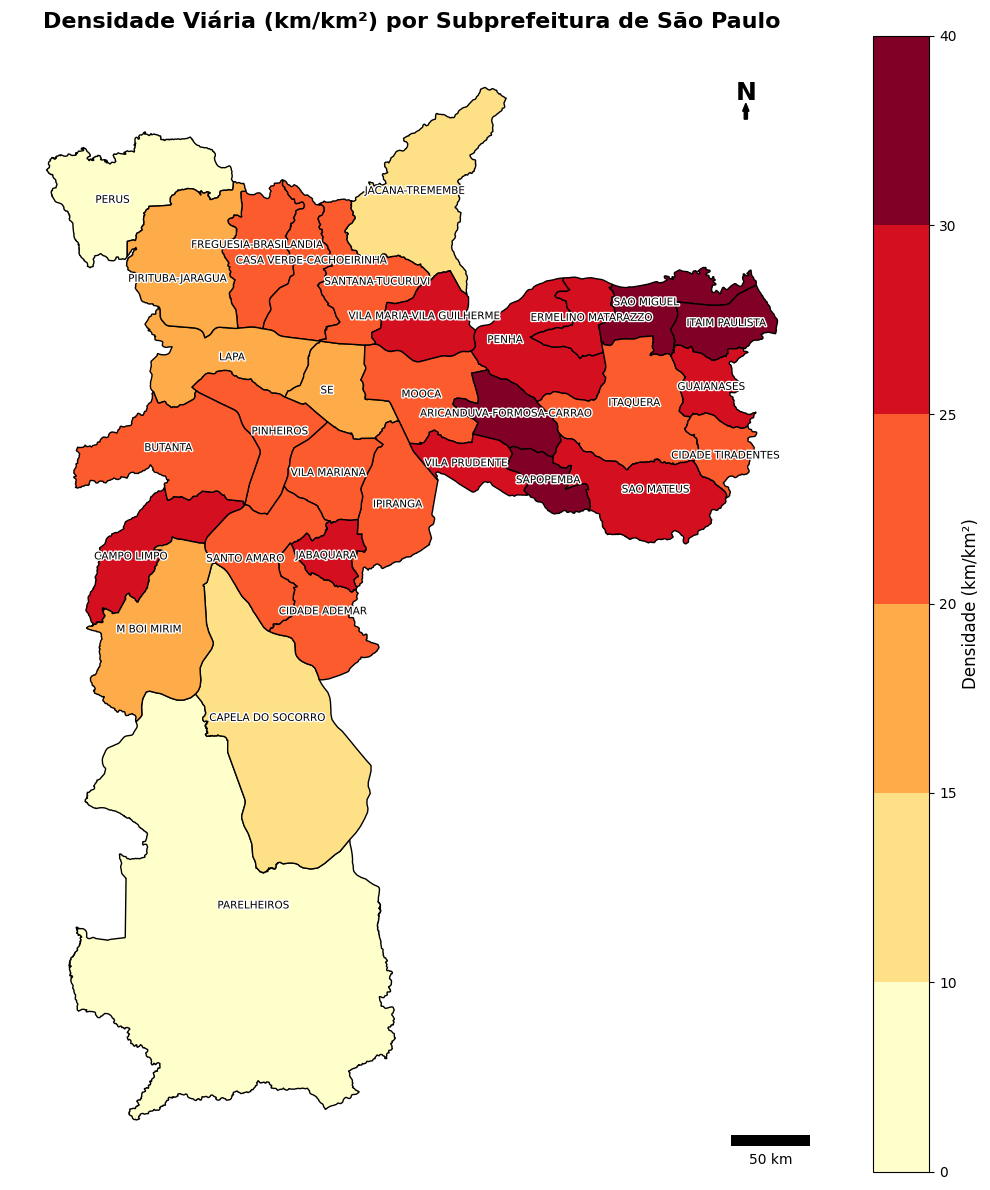

In [5]:
# 3. Mapa temático com a densidade viária

# Escolher paleta de cores mais contrastante
cmap_cores = 'YlOrRd'  # Outras opções: 'plasma', 'magma', 'cividis'
norm = Normalize(vmin=gdf_resultado['densidade_viaria'].min(), vmax=gdf_resultado['densidade_viaria'].max())

fig, ax = plt.subplots(figsize=(12, 12))

bins = [0, 10, 15, 20, 25, 30, 40]
norm = BoundaryNorm(bins, ncolors=256)

# Plot do mapa
gdf_resultado.plot(
    column='densidade_viaria',
    cmap=cmap_cores,
    norm=norm,
    legend=False,
    ax=ax,
    edgecolor='black'
)

# Adicionar título
ax.set_title('Densidade Viária (km/km²) por Subprefeitura de São Paulo', fontsize=16, weight='bold')

ajustes = {
    'SAO MIGUEL': (0.000, 0.006),
    'ITAQUERA': (0.015, 0.000),
    'PINHEIROS': (0.000, 0.007),
    'SANTANA-TUCURUVI': (0.000, -0.006),
    'FREGUESIA-BRASILANDIA': (0.000, 0.006),
    'PIRITUBA-JARAGUA': (0.000, -0.012),    # adicione outras que achar necessário
}

for idx, row in gdf_resultado.iterrows():
    nome = row[nome_coluna]
    x, y = row.geometry.representative_point().x, row.geometry.representative_point().y
    dx, dy = ajustes.get(nome, (0, 0))  # usa deslocamento personalizado se existir
    ax.text(
        x + dx, y + dy, nome,
        ha='center', va='center', fontsize=7.5, color='black',
        path_effects=[path_effects.withStroke(linewidth=2, foreground='white')]
    )


# Seta de norte com FancyArrow
xmin, ymin, xmax, ymax = gdf_resultado.total_bounds
arrow_x = xmax - 0.02
arrow_y = ymax - 0.02
ax.add_patch(FancyArrow(x=arrow_x, y=arrow_y, dx=0, dy=0.01,
                        width=0.002, head_width=0.004, head_length=0.005,
                        length_includes_head=True, color='black'))
ax.text(arrow_x, arrow_y + 0.012, 'N', fontsize=18, fontweight='bold', ha='center')

# Colorbar manual
sm = ScalarMappable(cmap=cmap_cores, norm=norm)
sm.set_array([])  # necessário para a colorbar funcionar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Densidade (km/km²)', fontsize=12)

scalebar = ScaleBar(1000, units='km', dimension='si-length', location='lower right', scale_loc='bottom', length_fraction=0.1)
ax.add_artist(scalebar)

# Remover eixos
ax.axis('off')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


### Gráfico em inglês

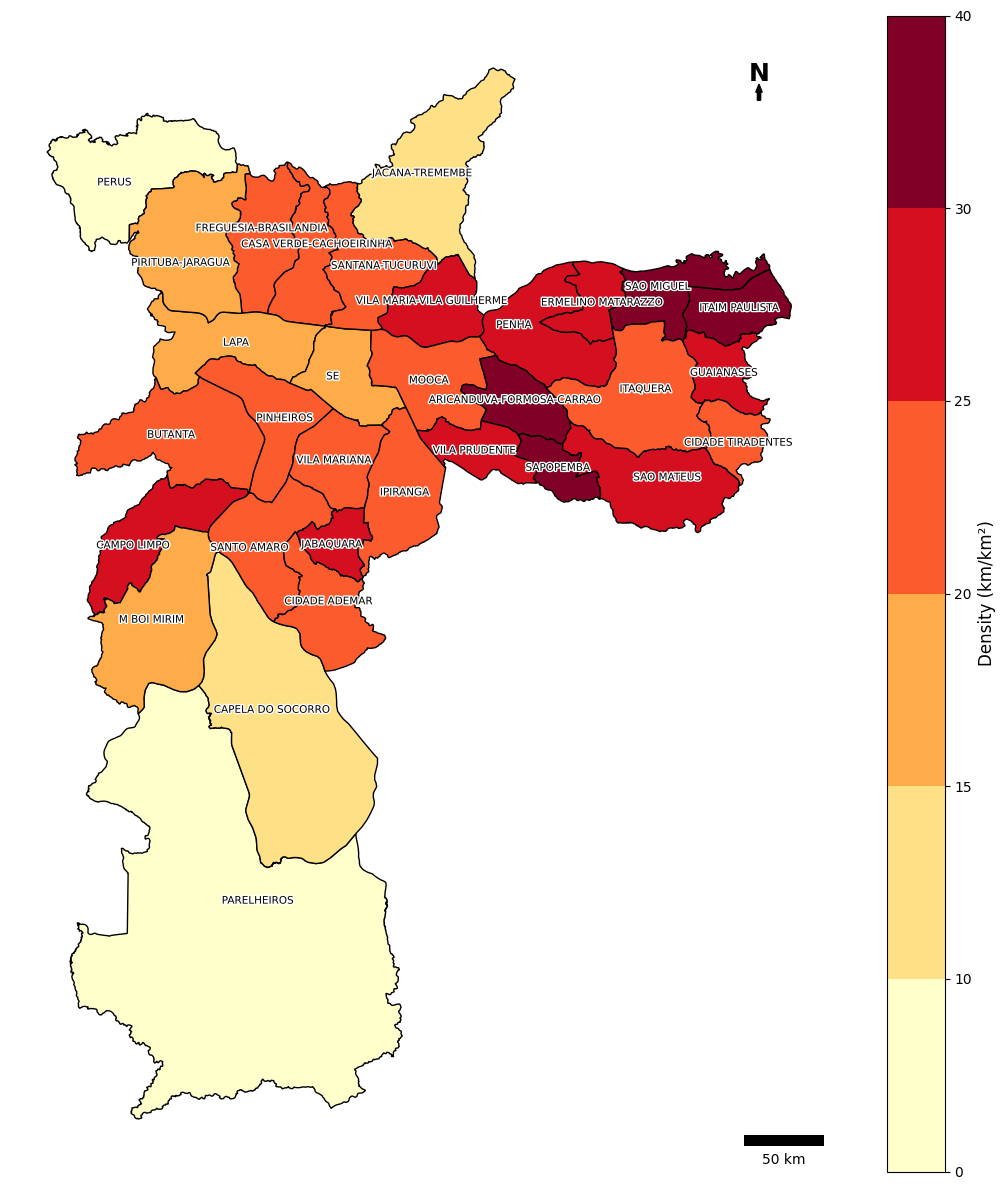

In [10]:
# 3. Mapa temático com a densidade viária

# Escolher paleta de cores mais contrastante
cmap_cores = 'YlOrRd'  # Outras opções: 'plasma', 'magma', 'cividis'
norm = Normalize(vmin=gdf_resultado['densidade_viaria'].min(), vmax=gdf_resultado['densidade_viaria'].max())

fig, ax = plt.subplots(figsize=(12, 12))

bins = [0, 10, 15, 20, 25, 30, 40]
norm = BoundaryNorm(bins, ncolors=256)

# Plot do mapa
gdf_resultado.plot(
    column='densidade_viaria',
    cmap=cmap_cores,
    norm=norm,
    legend=False,
    ax=ax,
    edgecolor='black'
)

# Adicionar título
#ax.set_title('Densidade Viária (km/km²) por Subprefeitura de São Paulo', fontsize=16, weight='bold')

ajustes = {
    'SAO MIGUEL': (0.000, 0.006),
    'ITAQUERA': (0.015, 0.000),
    'PINHEIROS': (0.000, 0.007),
    'SANTANA-TUCURUVI': (0.000, -0.006),
    'FREGUESIA-BRASILANDIA': (0.000, 0.006),
    'PIRITUBA-JARAGUA': (0.000, -0.012),    # adicione outras que achar necessário
}

for idx, row in gdf_resultado.iterrows():
    nome = row[nome_coluna]
    x, y = row.geometry.representative_point().x, row.geometry.representative_point().y
    dx, dy = ajustes.get(nome, (0, 0))  # usa deslocamento personalizado se existir
    ax.text(
        x + dx, y + dy, nome,
        ha='center', va='center', fontsize=7.5, color='black',
        path_effects=[path_effects.withStroke(linewidth=2, foreground='white')]
    )


# Seta de norte com FancyArrow
xmin, ymin, xmax, ymax = gdf_resultado.total_bounds
arrow_x = xmax - 0.02
arrow_y = ymax - 0.02
ax.add_patch(FancyArrow(x=arrow_x, y=arrow_y, dx=0, dy=0.01,
                        width=0.002, head_width=0.004, head_length=0.005,
                        length_includes_head=True, color='black'))
ax.text(arrow_x, arrow_y + 0.012, 'N', fontsize=18, fontweight='bold', ha='center')

# Colorbar manual
sm = ScalarMappable(cmap=cmap_cores, norm=norm)
sm.set_array([])  # necessário para a colorbar funcionar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Density (km/km²)', fontsize=12)

scalebar = ScaleBar(1000, units='km', dimension='si-length', location='lower right', scale_loc='bottom', length_fraction=0.1)
ax.add_artist(scalebar)

# Remover eixos
ax.axis('off')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


In [5]:
df_resiliencia = pd.read_csv('resiliencia_por_subprefeitura.csv')
#df_resiliencia.info()

# Calcular a mediana da resiliência por subprefeitura
df_mediana = df_resiliencia.groupby('Subprefeitura', as_index=False)['Resiliencia'].median()
df_mediana.rename(columns={'Resiliencia': 'mediana_resiliencia'}, inplace=True)

# Juntar com o GeoDataFrame contendo as geometrias
gdf_resultado = gdf_resultado.merge(df_mediana, left_on='subprefeitura', right_on='Subprefeitura', how='left')

In [8]:
df_mediana['mediana_resiliencia'].describe()

count    31.000000
mean      0.803918
std       0.174045
min       0.294500
25%       0.739841
50%       0.859543
75%       0.931503
max       0.979234
Name: mediana_resiliencia, dtype: float64

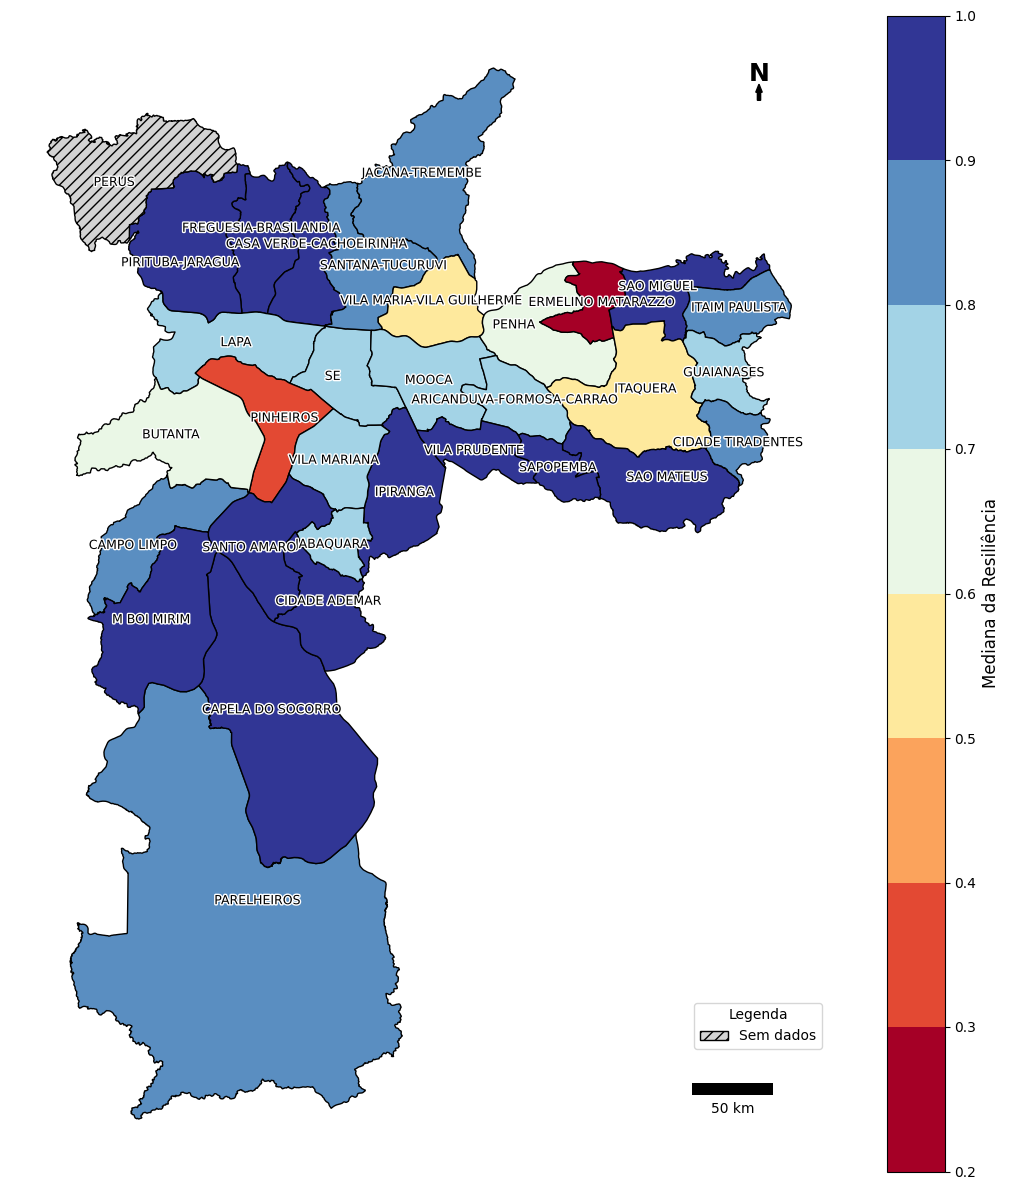

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import patheffects
from matplotlib.patches import FancyArrow
from matplotlib_scalebar.scalebar import ScaleBar

# CONFIGURAÇÕES BÁSICAS
nome_coluna = 'subprefeitura'  # ajuste conforme o nome correto da coluna com os nomes
coluna_valor = 'mediana_resiliencia'  # ajuste conforme o nome real da sua coluna

# Paleta e bins adaptados para resiliência entre 0 e 1
cmap_cores = 'RdYlBu'  # ou 'viridis', 'plasma', etc.
bins = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
norm = BoundaryNorm(bins, ncolors=256)

# FIGURA
fig, ax = plt.subplots(figsize=(12, 12))

# PLOT DO MAPA
gdf_resultado.plot(
    column=coluna_valor,
    cmap=cmap_cores,
    norm=norm,
    legend=False,
    ax=ax,
    edgecolor='black',
    missing_kwds={
        'color': 'lightgray',
        'edgecolor': 'black',
        'hatch': '///',
        'label': 'Sem dados'
        }
)

# TÍTULO
#ax.set_title('Mediana da Resiliência por Subprefeitura de São Paulo', fontsize=16, weight='bold')

# AJUSTES MANUAIS DE RÓTULOS (se necessário, adicione mais)
ajustes = {
    'SAO MIGUEL': (0.000, 0.006),
    'ITAQUERA': (0.015, 0.000),
    'PINHEIROS': (0.000, 0.007),
    'SANTANA-TUCURUVI': (0.000, -0.006),
    'FREGUESIA-BRASILANDIA': (0.000, 0.006),
    'PIRITUBA-JARAGUA': (0.000, -0.012),
}

# RÓTULOS
for idx, row in gdf_resultado.iterrows():
    nome = row[nome_coluna]
    x, y = row.geometry.representative_point().x, row.geometry.representative_point().y
    dx, dy = ajustes.get(nome, (0, 0))
    ax.text(
        x + dx, y + dy, nome,
        ha='center', va='center', fontsize=9, color='black',
        path_effects=[patheffects.withStroke(linewidth=2, foreground='white')]
    )

# SETA DO NORTE
xmin, ymin, xmax, ymax = gdf_resultado.total_bounds
arrow_x = xmax - 0.02
arrow_y = ymax - 0.02
ax.add_patch(FancyArrow(x=arrow_x, y=arrow_y, dx=0, dy=0.01,
                        width=0.002, head_width=0.004, head_length=0.005,
                        length_includes_head=True, color='black'))
ax.text(arrow_x, arrow_y + 0.012, 'N', fontsize=18, fontweight='bold', ha='center')

# COLORBAR
sm = ScalarMappable(cmap=cmap_cores, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Mediana da Resiliência', fontsize=12)

# ESCALA
#scalebar = ScaleBar(1, units='km', dimension='si-length', location='lower right',
#                    scale_loc='bottom', length_fraction=0.1, scale_factor=1000)

scalebar = ScaleBar(dx=1000, units='km', dimension='si-length', location='lower right',
                    scale_loc='bottom', length_fraction=0.1,
                    pad=2, border_pad=2)
ax.add_artist(scalebar)

# Adiciona entrada "Sem dados" na legenda
from matplotlib.patches import Patch
handles = [Patch(facecolor="lightgray", edgecolor="black", hatch="///", label="Sem dados")]
ax.legend(handles=handles, loc='lower right', fontsize=10, title='Legenda', bbox_to_anchor=(1, 0.1))


# AJUSTES FINAIS
ax.axis('off')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


#### Image in English

/var/folders/8y/8z4lzw294m5c0kf05d8ww4r00000gn/T/ipykernel_1911/3814875049.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


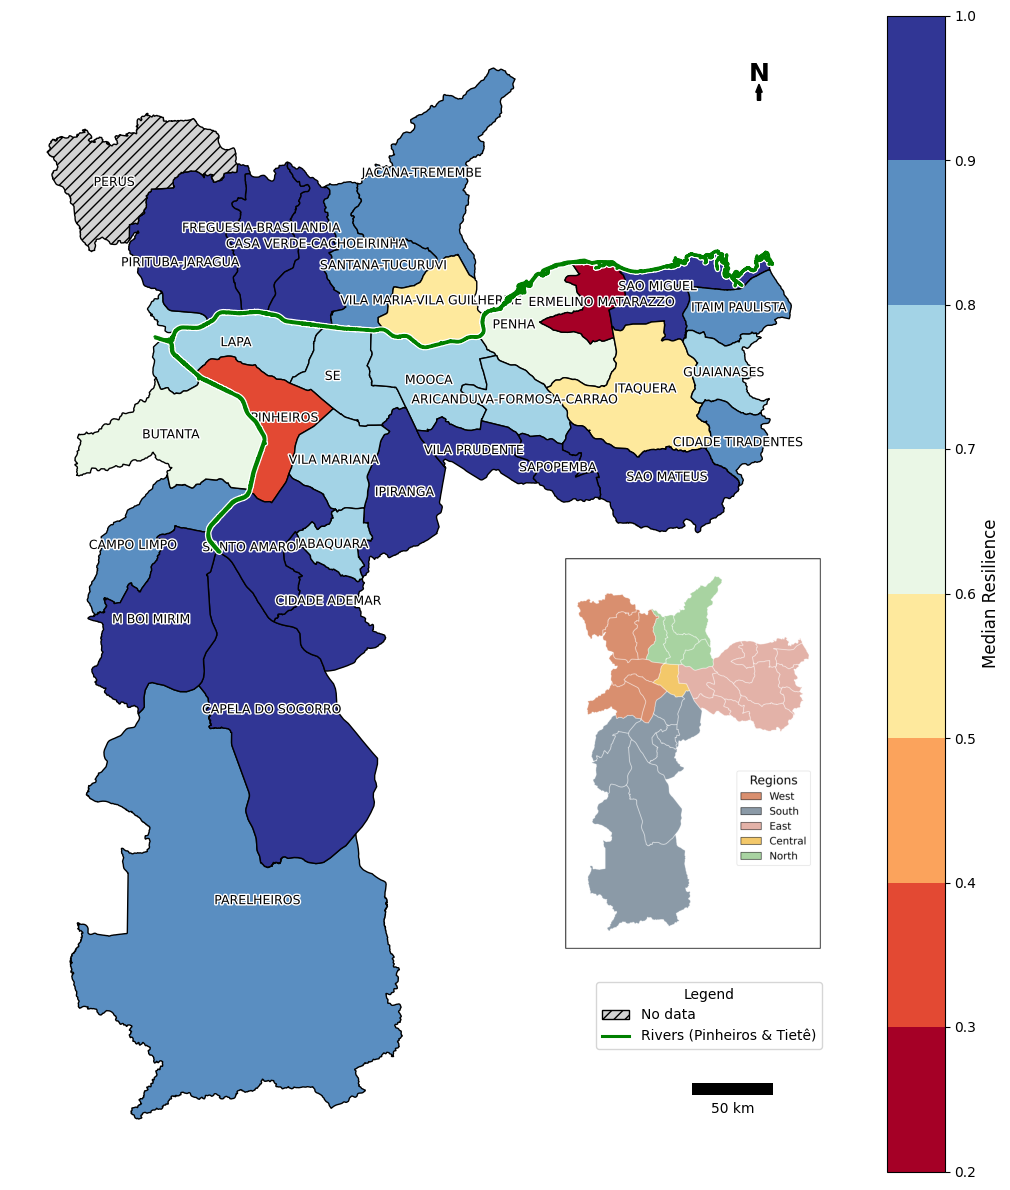

In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import patheffects
from matplotlib.patches import FancyArrow
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.lines import Line2D

# CONFIGURAÇÕES BÁSICAS
nome_coluna = 'subprefeitura'  # ajuste conforme o nome correto da coluna com os nomes
coluna_valor = 'mediana_resiliencia'  # ajuste conforme o nome real da sua coluna

# Paleta e bins adaptados para resiliência entre 0 e 1
cmap_cores = 'RdYlBu'  # ou 'viridis', 'plasma', etc.
bins = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
norm = BoundaryNorm(bins, ncolors=256)

# FIGURA
fig, ax = plt.subplots(figsize=(12, 12))

# PLOT DO MAPA
gdf_resultado.plot(
    column=coluna_valor,
    cmap=cmap_cores,
    norm=norm,
    legend=False,
    ax=ax,
    edgecolor='black',
    missing_kwds={
        'color': 'lightgray',
        'edgecolor': 'black',
        'hatch': '///',
        'label': 'Sem dados'
        }
)

gdf_agua = gpd.read_file(massa_agua)

# -------- 1) Garantir CRS compatível --------
# Se gdf_agua.crs for None, defina o CRS ORIGINAL do arquivo (não reprojeta!)
if gdf_agua.crs is None:
    # >>> só faça isso se tiver certeza do CRS original do arquivo de água
    # Ex.: SIRGAS 2000 / UTM 23S (São Paulo) -> "EPSG:31983"
    gdf_agua = gdf_agua.set_crs("EPSG:31983")

# Reprojetar água para o CRS do mapa
if gdf_agua.crs != gdf_resultado.crs:
    gdf_agua = gdf_agua.to_crs(gdf_resultado.crs)

# -------- 2) Filtrar Pinheiros e Tietê (tolerante a acento/maiúsculas) --------
def _normalize_series(s):
    s = s.astype(str)
    s = s.str.normalize("NFKD").str.encode("ascii", "ignore").str.decode("utf-8")
    return s.str.lower()

nome_norm = _normalize_series(gdf_agua["NOME"])
mask_pin  = nome_norm.str.contains(r"\bpinheiros\b", regex=True)
mask_tie  = nome_norm.str.contains(r"\btiete\b",    regex=True)

rios = gdf_agua.loc[mask_pin | mask_tie].copy()
rios["__nome__"] = np.where(mask_pin[mask_pin | mask_tie], "Pinheiros", "Tietê")

# Se vierem polígonos de massa d'água, usa só o contorno para parecer “rio”
if rios.geom_type.isin(["Polygon", "MultiPolygon"]).any():
    rios_line = rios.boundary
    rios = gpd.GeoDataFrame(rios.drop(columns="geometry"),
                            geometry=rios_line.values, crs=gdf_agua.crs)

# -------- 3) Recortar à área da cidade (opcional, para não “sobrar” fora) --------
#cidade = gdf_resultado.union_all()  # substitui unary_union (deprecated)
#rios = rios[rios.intersects(cidade)].copy()

# -------- 4) Plotar sobre o seu mapa (ax já existe) --------
#fig, ax = plt.subplots(figsize=(12, 12))
# halo branco
rios.plot(ax=ax, color="white", linewidth=4.0, zorder=7)
# cor dos rios (pode diferenciar se quiser)
cores = {"Pinheiros": "green", "Tietê": "green"}  # use cores diferentes se preferir
for nome, df_rio in rios.groupby("__nome__"):
    df_rio.plot(ax=ax, color=cores.get(nome, "#1f78b4"), linewidth=2.2, zorder=8, label=nome)
# TÍTULO
#ax.set_title('Mediana da Resiliência por Subprefeitura de São Paulo', fontsize=16, weight='bold')

# AJUSTES MANUAIS DE RÓTULOS (se necessário, adicione mais)
ajustes = {
    'SAO MIGUEL': (0.000, 0.006),
    'ITAQUERA': (0.015, 0.000),
    'PINHEIROS': (0.000, 0.007),
    'SANTANA-TUCURUVI': (0.000, -0.006),
    'FREGUESIA-BRASILANDIA': (0.000, 0.006),
    'PIRITUBA-JARAGUA': (0.000, -0.012),
}

# RÓTULOS
for idx, row in gdf_resultado.iterrows():
    nome = row[nome_coluna]
    x, y = row.geometry.representative_point().x, row.geometry.representative_point().y
    dx, dy = ajustes.get(nome, (0, 0))
    ax.text(
        x + dx, y + dy, nome,
        ha='center', va='center', fontsize=9, color='black',
        path_effects=[patheffects.withStroke(linewidth=2, foreground='white')]
    )

# SETA DO NORTE
xmin, ymin, xmax, ymax = gdf_resultado.total_bounds
arrow_x = xmax - 0.02
arrow_y = ymax - 0.02
ax.add_patch(FancyArrow(x=arrow_x, y=arrow_y, dx=0, dy=0.01,
                        width=0.002, head_width=0.004, head_length=0.005,
                        length_includes_head=True, color='black'))
ax.text(arrow_x, arrow_y + 0.012, 'N', fontsize=18, fontweight='bold', ha='center')

# COLORBAR
sm = ScalarMappable(cmap=cmap_cores, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Median Resilience', fontsize=12)

# ESCALA
#scalebar = ScaleBar(1, units='km', dimension='si-length', location='lower right',
#                    scale_loc='bottom', length_fraction=0.1, scale_factor=1000)

scalebar = ScaleBar(dx=1000, units='km', dimension='si-length', location='lower right',
                    scale_loc='bottom', length_fraction=0.1,
                    pad=2, border_pad=2)
ax.add_artist(scalebar)

# Adiciona entrada "Sem dados" na legenda
from matplotlib.patches import Patch
handles = [Patch(facecolor="lightgray", edgecolor="black", hatch="///", label="No data")]
ax.legend(handles=handles, loc='lower right', fontsize=10, title='Legend', bbox_to_anchor=(1, 0.1))

# --- novo handle para rios ---
rios_handle = Line2D(
    [0], [0],
    color="green", linewidth=2.2,
    label="Rivers (Pinheiros & Tietê)"
)
handles.append(rios_handle)

# --- aplicar legenda no canto inferior direito ---
ax.legend(
    handles=handles,
    loc='lower right',
    fontsize=10,
    title='Legend',
    bbox_to_anchor=(1, 0.1)
)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.image as mpimg

# --- carrega a imagem salva do mapa de regiões ---
img = mpimg.imread("mapa_regioes_com_moldura.png")

# --- cria eixo inset no canto inferior direito ---
axins = inset_axes(
    ax,
    width="70%",   # largura relativa
    height="70%",  # altura relativa
    bbox_to_anchor=(0.65, 0.18, 0.5, 0.5),  # (x0, y0, width, height) em FRAÇÕES
    bbox_transform=ax.transAxes,
    loc="lower left"
)

# mostra a imagem dentro do inset
axins.imshow(img)
axins.axis("off")   # sem eixos no inset

# AJUSTES FINAIS
ax.axis('off')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


In [10]:
# Cálculo da amplitude da resiliência
df_amplitude = df_resiliencia.groupby('Subprefeitura', as_index=False)['Resiliencia'].agg(lambda x: x.max() - x.min())
df_amplitude.rename(columns={'Resiliencia': 'amplitude_resiliencia'}, inplace=True)

gdf_resultado = gdf_resultado.merge(df_amplitude, left_on='subprefeitura', right_on='Subprefeitura', how='left')


In [11]:
df_amplitude['amplitude_resiliencia'].describe()


count    31.000000
mean      0.208931
std       0.134111
min       0.030392
25%       0.116004
50%       0.172713
75%       0.256374
max       0.597600
Name: amplitude_resiliencia, dtype: float64

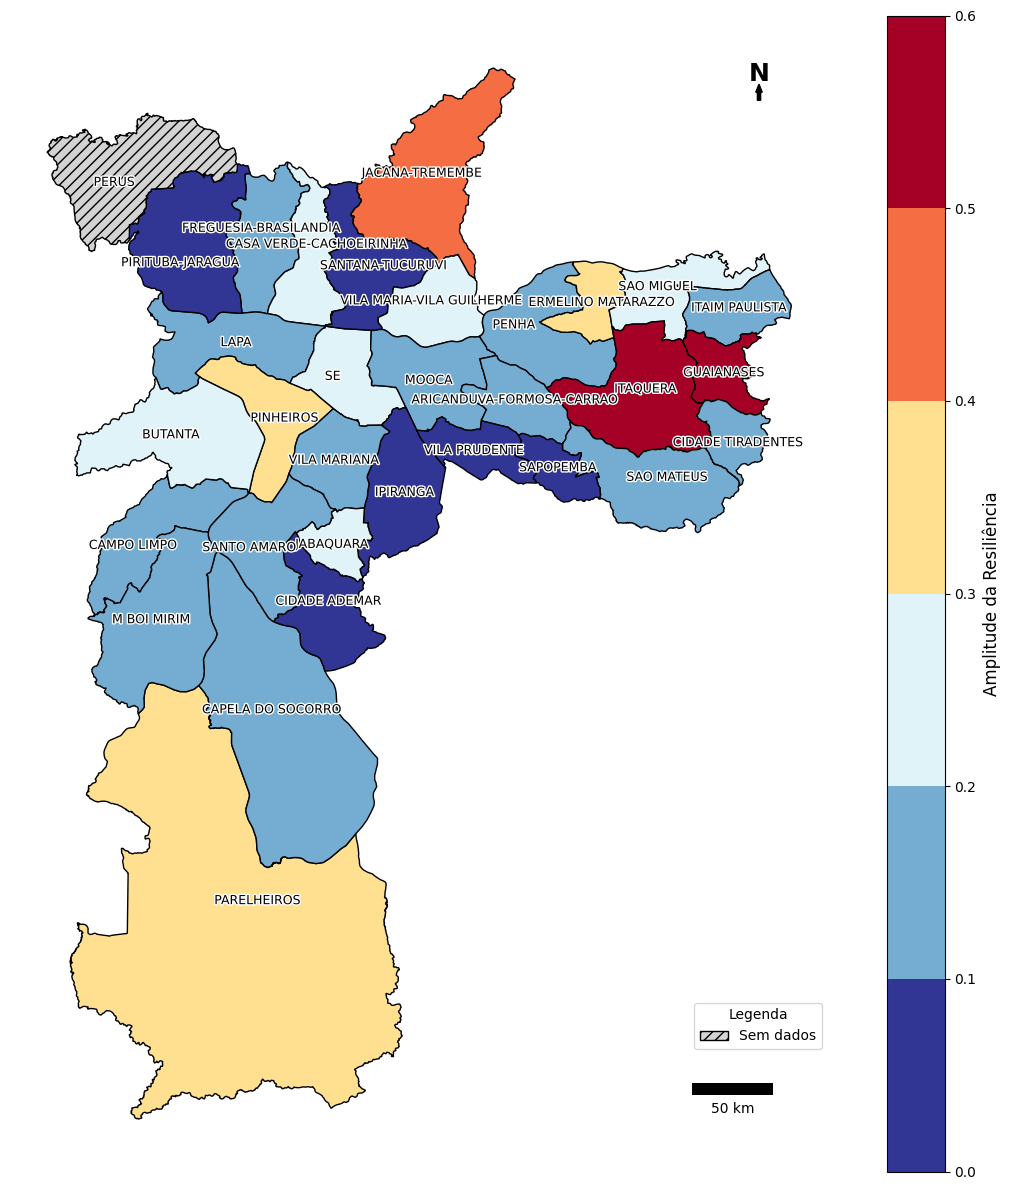

In [17]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import patheffects
from matplotlib.patches import FancyArrow
from matplotlib_scalebar.scalebar import ScaleBar

# CONFIGURAÇÕES BÁSICAS
nome_coluna = 'subprefeitura'  # ajuste conforme o nome correto da coluna com os nomes
coluna_valor = 'amplitude_resiliencia'  # ajuste conforme o nome real da sua coluna

# Paleta e bins adaptados para resiliência entre 0 e 1
cmap_cores = 'RdYlBu_r'  # ou 'viridis', 'plasma', etc.
bins = [0.00, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
norm = BoundaryNorm(bins, ncolors=256)

# FIGURA
fig, ax = plt.subplots(figsize=(12, 12))

# PLOT DO MAPA
gdf_resultado.plot(
    column=coluna_valor,
    cmap=cmap_cores,
    norm=norm,
    legend=False,
    ax=ax,
    edgecolor='black',missing_kwds={
        'color': 'lightgray',
        'edgecolor': 'black',
        'hatch': '///',
        'label': 'Sem dados'
        }
)

# TÍTULO
#ax.set_title('Amplitude da Resiliência por Subprefeitura de São Paulo', fontsize=16, weight='bold')

# AJUSTES MANUAIS DE RÓTULOS (se necessário, adicione mais)
ajustes = {
    'SAO MIGUEL': (0.000, 0.006),
    'ITAQUERA': (0.015, 0.000),
    'PINHEIROS': (0.000, 0.007),
    'SANTANA-TUCURUVI': (0.000, -0.006),
    'FREGUESIA-BRASILANDIA': (0.000, 0.006),
    'PIRITUBA-JARAGUA': (0.000, -0.012),
}

# RÓTULOS
for idx, row in gdf_resultado.iterrows():
    nome = row[nome_coluna]
    x, y = row.geometry.representative_point().x, row.geometry.representative_point().y
    dx, dy = ajustes.get(nome, (0, 0))
    ax.text(
        x + dx, y + dy, nome,
        ha='center', va='center', fontsize=9, color='black',
        path_effects=[patheffects.withStroke(linewidth=2, foreground='white')]
    )

# SETA DO NORTE
xmin, ymin, xmax, ymax = gdf_resultado.total_bounds
arrow_x = xmax - 0.02
arrow_y = ymax - 0.02
ax.add_patch(FancyArrow(x=arrow_x, y=arrow_y, dx=0, dy=0.01,
                        width=0.002, head_width=0.004, head_length=0.005,
                        length_includes_head=True, color='black'))
ax.text(arrow_x, arrow_y + 0.012, 'N', fontsize=18, fontweight='bold', ha='center')

# COLORBAR
sm = ScalarMappable(cmap=cmap_cores, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Amplitude da Resiliência', fontsize=12)

# ESCALA
scalebar = ScaleBar(dx=1000, units='km', dimension='si-length', location='lower right',
                    scale_loc='bottom', length_fraction=0.1,
                    pad=2, border_pad=2)
ax.add_artist(scalebar)

# Adiciona entrada "Sem dados" na legenda
from matplotlib.patches import Patch
handles = [Patch(facecolor="lightgray", edgecolor="black", hatch="///", label="Sem dados")]
ax.legend(handles=handles, loc='lower right', fontsize=10, title='Legenda', bbox_to_anchor=(1, 0.1))

# AJUSTES FINAIS
ax.axis('off')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


#### Image in English

In [12]:
def plot_rivers(ax, base_crs, rivers_path=None, rivers_gdf=None):
    """
    Desenha os rios Pinheiros e Tietê sobre o 'ax'.
    Passe 'rivers_path' para ler um arquivo (GeoJSON/Shapefile) com uma coluna 'name' (ou 'nome').
    Ou passe 'rivers_gdf' já carregado. Ambos devem conter essas duas geometrias (LineString/MultiLineString).
    """
    if rivers_gdf is None:
        if rivers_path is None:
            raise ValueError("Forneça rivers_path ou rivers_gdf.")
        rivers_gdf = gpd.read_file(rivers_path)

    # garantir mesmo CRS do mapa
    if rivers_gdf.crs != base_crs:
        rivers_gdf = rivers_gdf.to_crs(base_crs)

    # coluna de nome
    name_col = 'name' if 'name' in rivers_gdf.columns else ('nome' if 'nome' in rivers_gdf.columns else None)

    # filtra Pinheiros/Tietê (ou pega tudo se não achar col de nome)
    if name_col:
        sel = rivers_gdf[rivers_gdf[name_col].str.contains('tiet[eê]|pinheiros', case=False, na=False)]
        if sel.empty:
            sel = rivers_gdf.copy()
    else:
        sel = rivers_gdf.copy()

    # desenha com “halo” para destacar sobre os polígonos
    sel.plot(ax=ax, color='white', linewidth=4.5, zorder=7)
    sel.plot(ax=ax, color='#1f78b4', linewidth=2.2, zorder=8)

    # rótulos (se houver nome); pega um ponto na metade da linha
    if name_col:
        import matplotlib.patheffects as pe
        for _, row in sel.iterrows():
            try:
                p = row.geometry.interpolate(0.5, normalized=True)
                ax.text(
                    p.x, p.y,
                    row[name_col].upper(),
                    color='#1f78b4', fontsize=8.5, weight='bold',
                    ha='center', va='center',
                    path_effects=[pe.withStroke(linewidth=2, foreground='white')],
                    zorder=9
                )
            except Exception:
                pass


def zones_inset_from_file(ax, base_crs, zones_path, zone_col='zone',
                          bounds=(0.70, 0.70, 0.25, 0.25)):
    """
    Desenha um inset com as Zonas (arquivo com polígonos e coluna 'zone' contendo
    'West','South','East','Center','North' – ou equivalentes).
    """
    zones = gpd.read_file(zones_path)
    if zones.crs != base_crs:
        zones = zones.to_crs(base_crs)

    # cores por zona (ajuste nomes se necessário)
    palette = {
        'West':'#7fc97f', 'South':'#beaed4', 'East':'#fdc086',
        'Center':'#ffff99', 'North':'#386cb0'
    }
    zones['__color__'] = zones[zone_col].map(palette).fillna('#cccccc')

    ax_in = inset_axes(ax, width=bounds[2], height=bounds[3],
                       bbox_to_anchor=bounds, bbox_transform=ax.transAxes, borderpad=0)

    zones.plot(ax=ax_in, color=zones['__color__'], edgecolor='black', linewidth=0.6)
    ax_in.set_xticks([]); ax_in.set_yticks([]); ax_in.set_title('City Zones', fontsize=10, pad=2)
    for sp in ax_in.spines.values():
        sp.set_visible(True); sp.set_linewidth(1)

    # legenda compacta dentro do inset
    import matplotlib.patches as mpatches
    handles = [mpatches.Patch(facecolor=c, edgecolor='black', label=k) for k, c in palette.items()]
    ax_in.legend(handles=handles, fontsize=8, frameon=True, loc='lower left', ncol=1)


def zones_inset_heuristic(ax, gdf, bounds=(0.70, 0.70, 0.25, 0.25)):
    """
    SEM arquivo de zonas: cria um inset “heurístico”.
    Classifica cada subprefeitura pela posição do centróide relativo ao centro da cidade.
    Tudo que estiver num raio curto vira 'Center'; o resto vira N/S/E/W por quadrante.
    """
    city_poly = gdf.unary_union
    city_cent = city_poly.centroid
    cx, cy = city_cent.x, city_cent.y

    # raio para definir "Centro": ~8% da maior dimensão do bounding box
    xmin, ymin, xmax, ymax = gdf.total_bounds
    city_d = max(xmax-xmin, ymax-ymin)
    center_r = 0.08 * city_d

    def classify(pt):
        dx, dy = pt.x - cx, pt.y - cy
        r = (dx*dx + dy*dy) ** 0.5
        if r <= center_r:
            return 'Center'
        # quadrantes
        if abs(dx) >= abs(dy):
            return 'East' if dx > 0 else 'West'
        else:
            return 'North' if dy > 0 else 'South'

    tmp = gdf.copy()
    tmp['__centroid__'] = tmp.geometry.centroid
    tmp['zone'] = tmp['__centroid__'].apply(classify)

    zones = tmp.dissolve(by='zone', as_index=False)

    palette = {
        'West':'#7fc97f', 'South':'#beaed4', 'East':'#fdc086',
        'Center':'#ffff99', 'North':'#386cb0'
    }
    zones['__color__'] = zones['zone'].map(palette).fillna('#cccccc')

    ax_in = inset_axes(ax, width=bounds[2], height=bounds[3],
                       bbox_to_anchor=bounds, bbox_transform=ax.transAxes, borderpad=0)

    zones.plot(ax=ax_in, color=zones['__color__'], edgecolor='black', linewidth=0.6)
    ax_in.set_xticks([]); ax_in.set_yticks([]); ax_in.set_title('City Zones (heuristic)', fontsize=10, pad=2)
    for sp in ax_in.spines.values():
        sp.set_visible(True); sp.set_linewidth(1)

    import matplotlib.patches as mpatches
    handles = [mpatches.Patch(facecolor=c, edgecolor='black', label=k) for k, c in palette.items()]
    ax_in.legend(handles=handles, fontsize=8, frameon=True, loc='lower left', ncol=1)


/var/folders/8y/8z4lzw294m5c0kf05d8ww4r00000gn/T/ipykernel_25857/1195955642.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


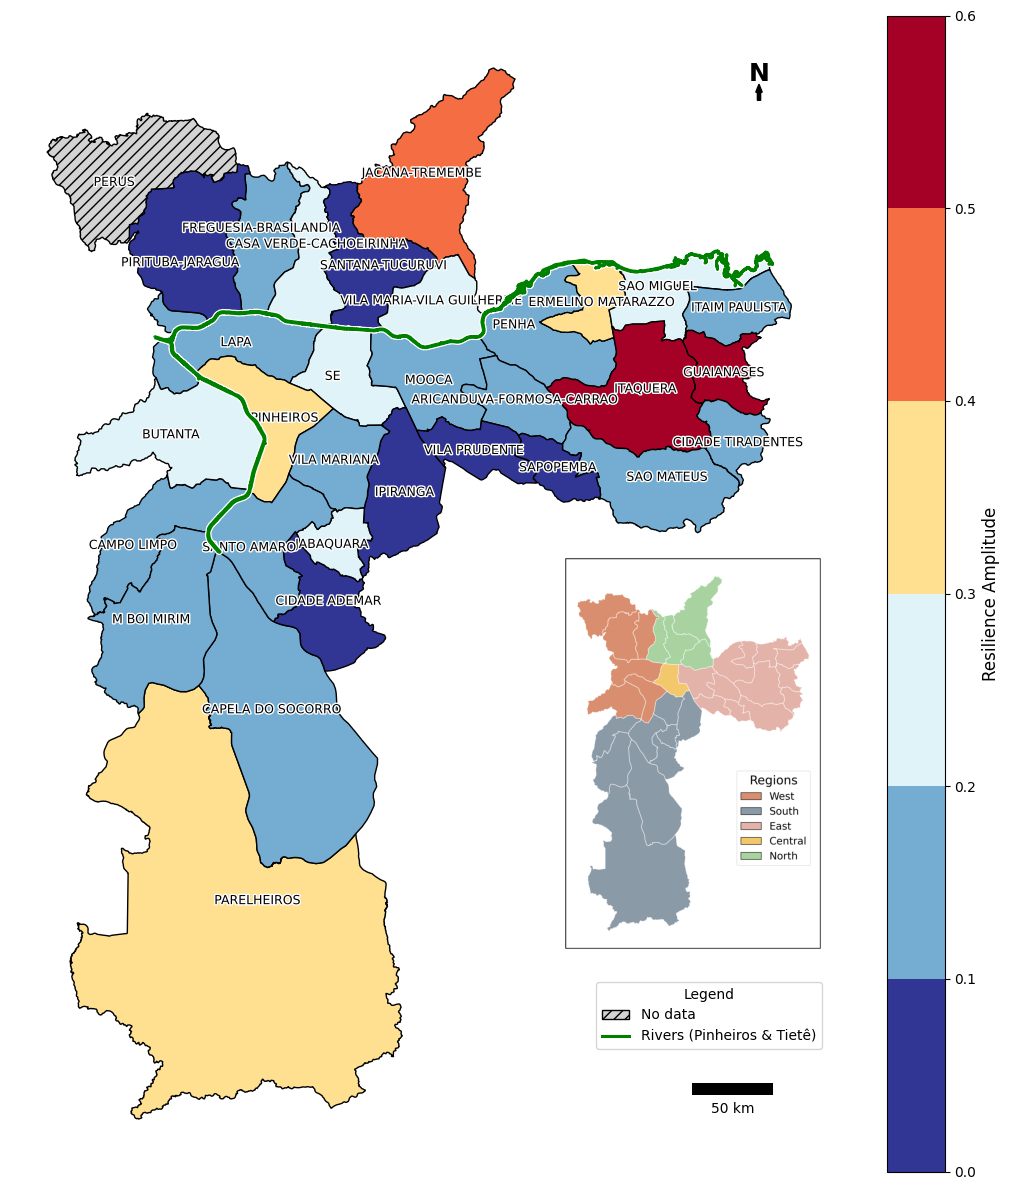

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import patheffects
from matplotlib.patches import FancyArrow
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import geopandas as gpd
import matplotlib.patheffects as pe
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# CONFIGURAÇÕES BÁSICAS
nome_coluna = 'subprefeitura'  # ajuste conforme o nome correto da coluna com os nomes
coluna_valor = 'amplitude_resiliencia'  # ajuste conforme o nome real da sua coluna

# Paleta e bins adaptados para resiliência entre 0 e 1
cmap_cores = 'RdYlBu_r'  # ou 'viridis', 'plasma', etc.
bins = [0.00, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
norm = BoundaryNorm(bins, ncolors=256)

# FIGURA
fig, ax = plt.subplots(figsize=(12, 12))

# PLOT DO MAPA
gdf_resultado.plot(
    column=coluna_valor,
    cmap=cmap_cores,
    norm=norm,
    legend=False,
    ax=ax,
    edgecolor='black',missing_kwds={
        'color': 'lightgray',
        'edgecolor': 'black',
        'hatch': '///',
        'label': 'Sem dados'
        }
)

gdf_agua = gpd.read_file(massa_agua)

# -------- 1) Garantir CRS compatível --------
# Se gdf_agua.crs for None, defina o CRS ORIGINAL do arquivo (não reprojeta!)
if gdf_agua.crs is None:
    # >>> só faça isso se tiver certeza do CRS original do arquivo de água
    # Ex.: SIRGAS 2000 / UTM 23S (São Paulo) -> "EPSG:31983"
    gdf_agua = gdf_agua.set_crs("EPSG:31983")

# Reprojetar água para o CRS do mapa
if gdf_agua.crs != gdf_resultado.crs:
    gdf_agua = gdf_agua.to_crs(gdf_resultado.crs)

# -------- 2) Filtrar Pinheiros e Tietê (tolerante a acento/maiúsculas) --------
def _normalize_series(s):
    s = s.astype(str)
    s = s.str.normalize("NFKD").str.encode("ascii", "ignore").str.decode("utf-8")
    return s.str.lower()

nome_norm = _normalize_series(gdf_agua["NOME"])
mask_pin  = nome_norm.str.contains(r"\bpinheiros\b", regex=True)
mask_tie  = nome_norm.str.contains(r"\btiete\b",    regex=True)

rios = gdf_agua.loc[mask_pin | mask_tie].copy()
rios["__nome__"] = np.where(mask_pin[mask_pin | mask_tie], "Pinheiros", "Tietê")

# Se vierem polígonos de massa d'água, usa só o contorno para parecer “rio”
if rios.geom_type.isin(["Polygon", "MultiPolygon"]).any():
    rios_line = rios.boundary
    rios = gpd.GeoDataFrame(rios.drop(columns="geometry"),
                            geometry=rios_line.values, crs=gdf_agua.crs)

# -------- 3) Recortar à área da cidade (opcional, para não “sobrar” fora) --------
#cidade = gdf_resultado.union_all()  # substitui unary_union (deprecated)
#rios = rios[rios.intersects(cidade)].copy()

# -------- 4) Plotar sobre o seu mapa (ax já existe) --------
#fig, ax = plt.subplots(figsize=(12, 12))
# halo branco
rios.plot(ax=ax, color="white", linewidth=4.0, zorder=7)
# cor dos rios (pode diferenciar se quiser)
cores = {"Pinheiros": "green", "Tietê": "green"}  # use cores diferentes se preferir
for nome, df_rio in rios.groupby("__nome__"):
    df_rio.plot(ax=ax, color=cores.get(nome, "#1f78b4"), linewidth=2.2, zorder=8, label=nome)

# TÍTULO
#ax.set_title('Amplitude da Resiliência por Subprefeitura de São Paulo', fontsize=16, weight='bold')

# AJUSTES MANUAIS DE RÓTULOS (se necessário, adicione mais)
ajustes = {
    'SAO MIGUEL': (0.000, 0.006),
    'ITAQUERA': (0.015, 0.000),
    'PINHEIROS': (0.000, 0.007),
    'SANTANA-TUCURUVI': (0.000, -0.006),
    'FREGUESIA-BRASILANDIA': (0.000, 0.006),
    'PIRITUBA-JARAGUA': (0.000, -0.012),
}

# RÓTULOS
for idx, row in gdf_resultado.iterrows():
    nome = row[nome_coluna]
    x, y = row.geometry.representative_point().x, row.geometry.representative_point().y
    dx, dy = ajustes.get(nome, (0, 0))
    ax.text(
        x + dx, y + dy, nome,
        ha='center', va='center', fontsize=9, color='black',
        path_effects=[patheffects.withStroke(linewidth=2, foreground='white')]
    )

# SETA DO NORTE
xmin, ymin, xmax, ymax = gdf_resultado.total_bounds
arrow_x = xmax - 0.02
arrow_y = ymax - 0.02
ax.add_patch(FancyArrow(x=arrow_x, y=arrow_y, dx=0, dy=0.01,
                        width=0.002, head_width=0.004, head_length=0.005,
                        length_includes_head=True, color='black'))
ax.text(arrow_x, arrow_y + 0.012, 'N', fontsize=18, fontweight='bold', ha='center')

# COLORBAR
sm = ScalarMappable(cmap=cmap_cores, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Resilience Amplitude', fontsize=12)

# ESCALA
scalebar = ScaleBar(dx=1000, units='km', dimension='si-length', location='lower right',
                    scale_loc='bottom', length_fraction=0.1,
                    pad=2, border_pad=2)
ax.add_artist(scalebar)

# Adiciona entrada "Sem dados" na legenda
from matplotlib.patches import Patch
handles = [Patch(facecolor="lightgray", edgecolor="black", hatch="///", label="No data")]
ax.legend(handles=handles, loc='lower right', fontsize=10, title='Legend', bbox_to_anchor=(1, 0.1))

# --- novo handle para rios ---
rios_handle = Line2D(
    [0], [0],
    color="green", linewidth=2.2,
    label="Rivers (Pinheiros & Tietê)"
)
handles.append(rios_handle)

# --- aplicar legenda no canto inferior direito ---
ax.legend(
    handles=handles,
    loc='lower right',
    fontsize=10,
    title='Legend',
    bbox_to_anchor=(1, 0.1)
)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.image as mpimg

# --- carrega a imagem salva do mapa de regiões ---
img = mpimg.imread("mapa_regioes_com_moldura.png")

# --- cria eixo inset no canto inferior direito ---
axins = inset_axes(
    ax,
    width="70%",   # largura relativa
    height="70%",  # altura relativa
    bbox_to_anchor=(0.65, 0.18, 0.5, 0.5),  # (x0, y0, width, height) em FRAÇÕES
    bbox_transform=ax.transAxes,
    loc="lower left"
)

# mostra a imagem dentro do inset
axins.imshow(img)
axins.axis("off")   # sem eixos no inset

# AJUSTES FINAIS
ax.axis('off')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


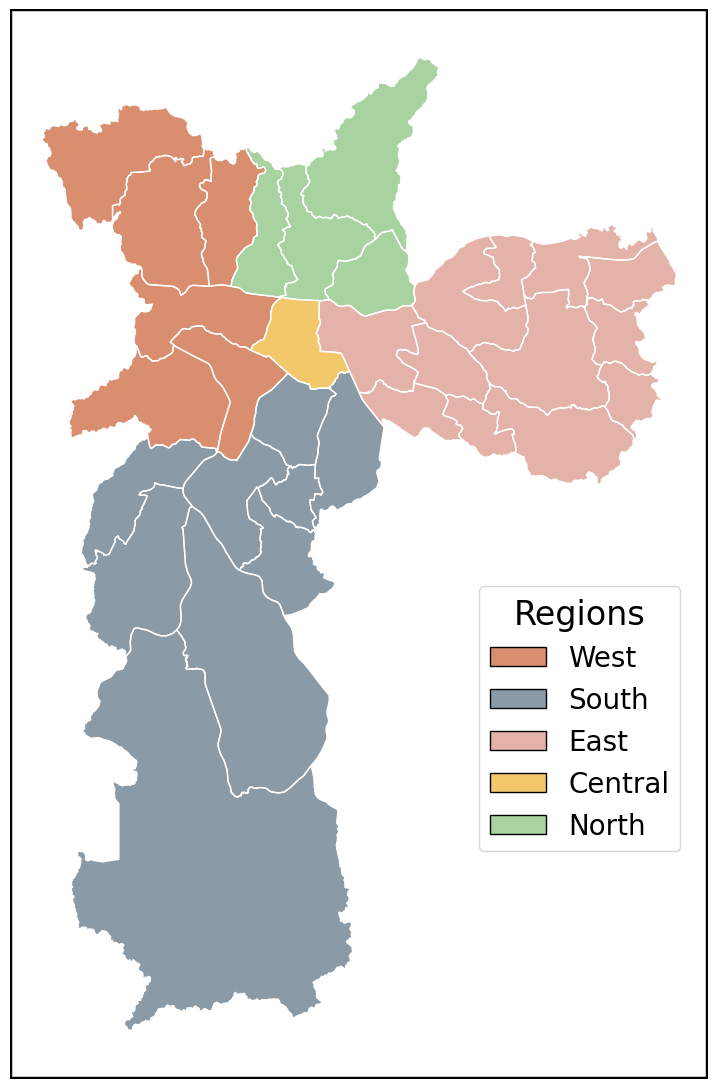

In [14]:
# -*- coding: utf-8 -*-
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
from matplotlib_scalebar.scalebar import ScaleBar
import unicodedata
import numpy as np

# ------------------------------------------------------------
# 1) Carregar subprefeituras
# ------------------------------------------------------------
path_subpref = subprefeituras_shp  # <-- troque pelo seu arquivo
gdf = gpd.read_file(path_subpref)

# Nome da coluna com as subprefeituras (ajuste se necessário)
# (exemplos comuns: "subprefeitura", "NOME", "NOME_SUBPREF")
name_col = "sp_nome"
for c in gdf.columns:
    if str(c).lower() in {"subprefeitura","subprefeituras","nome","nome_subpref"}:
        name_col = c
        break
if name_col is None:
    # escolha a primeira coluna de texto como fallback
    name_col = next((c for c in gdf.columns if gdf[c].dtype==object), gdf.columns[0])

# Trabalhar em CRS métrico para escala correta
target_crs = "EPSG:31983"   # SIRGAS 2000 / UTM 23S (SP)
if gdf.crs is None:
    # se seu arquivo não traz CRS, atribua o correto ANTES de reprojetar
    gdf = gdf.set_crs(target_crs)
gdf = gdf.to_crs(target_crs)

# ------------------------------------------------------------
# 2) Normalização e mapeamento explícito (ajuste livre)
#    (neste dicionário já deixei um mapeamento alinhado à figura)
# ------------------------------------------------------------
def norm(s: str) -> str:
    s = (s or "").upper().strip()
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("utf-8")
    s = s.replace("  ", " ").replace("'", "")
    return s

# nomes esperados (normalizados) -> REGIÃO
ZONA_BY_SUBPREF = {
    # --- OESTE ---
    "PERUS": "Oeste",
    "PIRITUBA-JARAGUA": "Oeste",
    "FREGUESIA-BRASILANDIA": "Oeste",
    "LAPA": "Oeste",
    "PINHEIROS": "Oeste",
    "BUTANTA": "Oeste",

    # --- NORTE ---
    "JACANA-TREMEMBE": "Norte",
    "SANTANA-TUCURUVI": "Norte",
    "CASA VERDE-CACHOEIRINHA": "Norte",
    "VILA MARIA-VILA GUILHERME": "Norte",

    # --- LESTE ---
    "ERMELINO MATARAZZO": "Leste",
    "SAO MIGUEL": "Leste",
    "ITAIM PAULISTA": "Leste",
    "PENHA": "Leste",
    "ITAQUERA": "Leste",
    "GUAIANASES": "Leste",
    "SAO MATEUS": "Leste",
    "CIDADE TIRADENTES": "Leste",
    "ARICANDUVA-FORMOSA-CARRAO": "Leste",
    "MOOCA": "Leste",
    "VILA PRUDENTE": "Leste",
    "SAPOPEMBA": "Leste",

    # --- SUL ---
    "CAMPO LIMPO": "Sul",
    "M BOI MIRIM": "Sul",
    "CAPELA DO SOCORRO": "Sul",
    "PARELHEIROS": "Sul",
    "SANTO AMARO": "Sul",
    "JABAQUARA": "Sul",
    "CIDADE ADEMAR": "Sul",
    "IPIRANGA": "Sul",
    "VILA MARIANA": "Sul",

    # --- CENTRO ---
    "SE": "Centro",
}

# aplicar mapeamento com fallback heurístico (se algum nome não estiver no dicionário)
gdf["_norm_nome"] = gdf[name_col].astype(str).map(norm)

# Heurística de quadrante + raio central (só usada para faltantes)
city = gdf.union_all()
cx, cy = city.centroid.x, city.centroid.y
xmin, ymin, xmax, ymax = gdf.total_bounds
dmax = max(xmax-xmin, ymax-ymin)
r_centro = 0.085 * dmax  # ~8.5% do maior lado vira "Centro" na heurística

def heuristica_regiao(geom):
    p = geom.centroid
    dx, dy = p.x - cx, p.y - cy
    r = (dx*dx + dy*dy)**0.5
    if r <= r_centro:
        return "Centro"
    if abs(dx) >= abs(dy):
        return "Leste" if dx > 0 else "Oeste"
    else:
        return "Norte" if dy > 0 else "Sul"

def pick_regiao(row):
    nome_n = row["_norm_nome"]
    if nome_n in ZONA_BY_SUBPREF:
        return ZONA_BY_SUBPREF[nome_n]
    return heuristica_regiao(row.geometry)

gdf["regiao"] = gdf.apply(pick_regiao, axis=1)

# relatar nomes não mapeados explicitamente (se houver)
faltantes = sorted(set(gdf["_norm_nome"]) - set(ZONA_BY_SUBPREF.keys()))
if faltantes:
    print("⚠️ Subprefeituras não cobertas no dicionário (usaram heurística):")
    for x in faltantes: print("  -", x)

# ------------------------------------------------------------
# 3) Regiões dissolvidas + paleta
# ------------------------------------------------------------
zonas = gdf[["regiao","geometry"]].dissolve(by="regiao", as_index=False)

palette = {
    "Oeste":  "#d98f6f",  # alaranjado suave
    "Sul":    "#8b9aa7",  # cinza-azulado
    "Leste":  "#e3b2a8",  # rosado leve
    "Centro": "#f3c86a",  # amarelo
    "Norte":  "#a8d3a1",  # verde claro
}
zonas["_color"] = zonas["regiao"].map(palette).fillna("#cccccc")

# ------------------------------------------------------------
# 4) Plot estilizado
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8.5, 11))

# preencher por região
zonas.plot(ax=ax, color=zonas["_color"], edgecolor="none", zorder=1)

# limites das subprefeituras em branco
gdf.boundary.plot(ax=ax, color="white", linewidth=1.0, zorder=2)

# rótulos "Zona ..." no centróide de cada região
#for _, r in zonas.iterrows():
#    p = r.geometry.representative_point()
#    ax.text(
#        p.x, p.y, f"Zona {r['regiao']}",
#        ha="center", va="center", fontsize=12, weight="bold", color="black",
#        zorder=3, path_effects=[pe.withStroke(linewidth=3, foreground="white")]
#    )

# legenda compacta
#handles = [mpatches.Patch(facecolor=palette[k], edgecolor="black", label=f"Zona {k}")
#           for k in ["Oeste","Sul","Leste","Centro","Norte"] if (zonas["regiao"]==k).any()]
#ax.legend(handles=handles, loc="lower left", fontsize=10, frameon=True, title="Regiões")

# legenda em inglês, maior e no canto inferior direito
labels_en = {
    "Oeste": "West",
    "Sul": "South",
    "Leste": "East",
    "Centro": "Central",
    "Norte": "North"
}

handles = [
    mpatches.Patch(
        facecolor=palette[k], edgecolor="black", label=labels_en[k]
    )
    for k in ["Oeste","Sul","Leste","Centro","Norte"] if (zonas["regiao"]==k).any()
]

ax.legend(
    handles=handles,
    loc="lower right",
    bbox_to_anchor=(0.98, 0.2),  # move a legenda um pouco para fora
    fontsize=20,
    frameon=True,
    title="Regions",
    title_fontsize=24
)

# escala métrica
#ax.set_aspect(1)
#sb = ScaleBar(dx=1, units="m", dimension="si-length", location="lower right",
#              scale_loc="bottom", length_fraction=0.20, pad=0.6, border_pad=0.8)
#ax.add_artist(sb)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Supondo que `fig, ax = plt.subplots(...)` já foi feito e o mapa plotado

# --- adicionar moldura preta ao redor do gráfico ---
# pega os limites atuais
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

# cria um retângulo como moldura
rect = mpatches.Rectangle(
    (xmin, ymin),           # canto inferior esquerdo
    xmax - xmin,            # largura
    ymax - ymin,            # altura
    linewidth=3.2,
    edgecolor="black",
    facecolor="none",
    zorder=10
)
ax.add_patch(rect)

# salva o mapa em alta resolução, pronto para ser usado como inset
plt.savefig("mapa_regioes_com_moldura.png", dpi=300, bbox_inches="tight", pad_inches=0.2)
#plt.show()


#ax.set_xticks([]); ax.set_yticks([])
ax.set_axis_off()
plt.tight_layout()

# ------------------------------------------------------------
# 5) Exportar (para usar como inset depois, se quiser)
# ------------------------------------------------------------
#out_png = "mapa_regioes_sp.png"
#out_geojson = "regioes_sp_dissolvidas.geojson"
#plt.savefig(out_png, dpi=300, bbox_inches="tight")
#zonas[["regiao","geometry"]].to_file(out_geojson, driver="GeoJSON")
plt.savefig("mapa_regioes_com_moldura.png", dpi=300, bbox_inches="tight", pad_inches=0.2)
plt.show()

#print("✅ Salvos:")
#print(" -", out_png)
#print(" -", out_geojson)


/var/folders/8y/8z4lzw294m5c0kf05d8ww4r00000gn/T/ipykernel_23998/1394585017.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


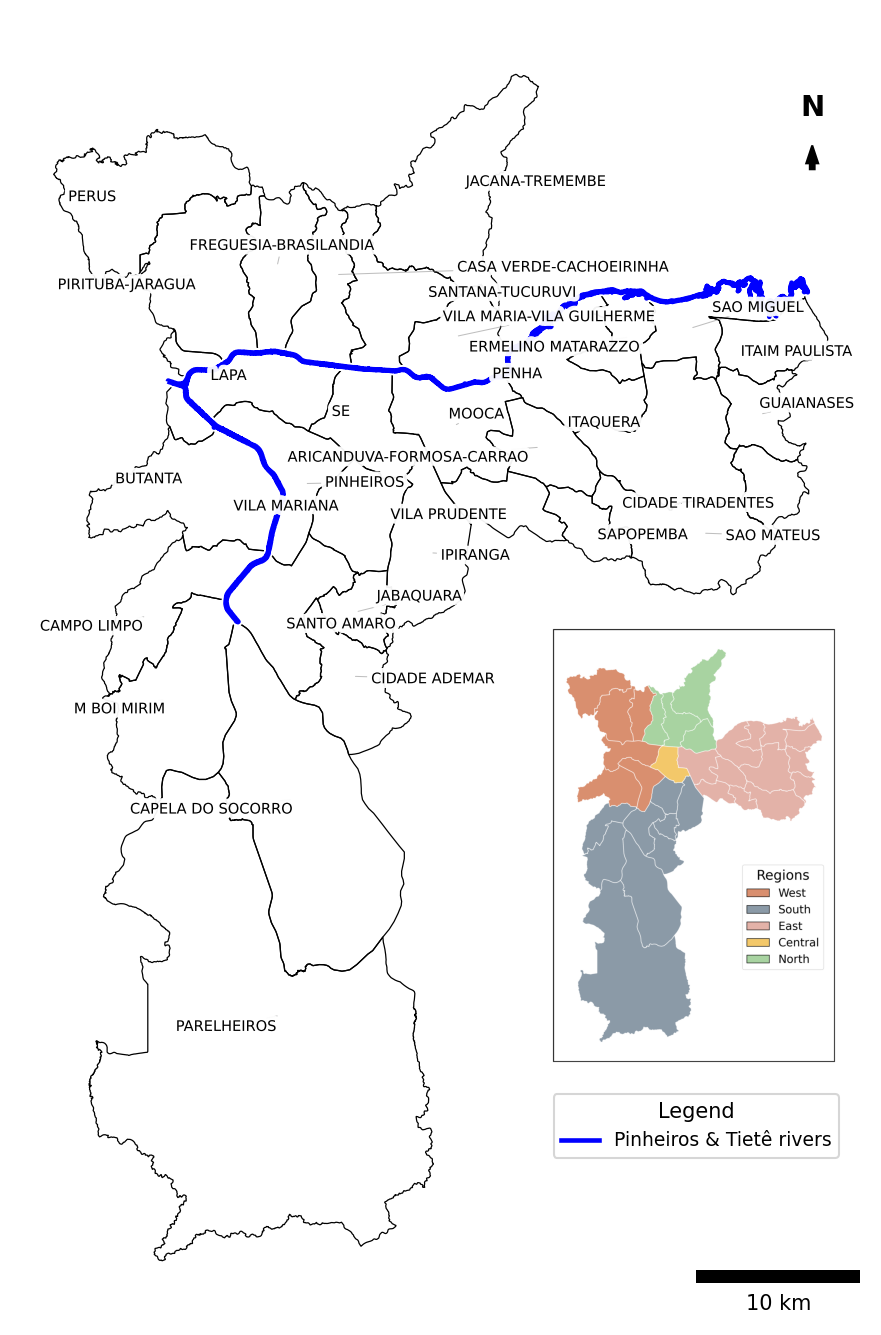

In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib_scalebar.scalebar import ScaleBar
from adjustText import adjust_text  # pip install adjustText
import numpy as np
from matplotlib.patches import FancyArrow
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.image as mpimg
from matplotlib.lines import Line2D

# ------------------------------
# 0) Ler shapefile principal
# ------------------------------
gdf = gpd.read_file(subprefeituras_shp)

# Trabalhar em CRS métrico
target_crs = "EPSG:31983"
if gdf.crs is None:
    # Atenção: só faça set_crs se tiver CERTEZA do CRS original
    gdf = gdf.set_crs(target_crs)
else:
    gdf = gdf.to_crs(target_crs)

# ------------------------------
# 1) Figura
# ------------------------------
fig, ax = plt.subplots(figsize=(9, 9), dpi=150)

# Mapa sem preenchimento (apenas contorno)
gdf.plot(ax=ax, edgecolor="black", linewidth=0.6, facecolor="none")

# ------------------------------
# 2) Massa d'água e seleção Pinheiros/Tietê
# ------------------------------
gdf_agua = gpd.read_file(massa_agua)

# Garantir CRS compatível
if gdf_agua.crs is None:
    # Ajuste aqui se souber o CRS original da camada de água
    gdf_agua = gdf_agua.set_crs(target_crs)
else:
    gdf_agua = gdf_agua.to_crs(gdf.crs)

# Nome do atributo com o nome d'água pode variar; tenta alguns padrões
for cand in ["NOME", "Nome", "name", "nome"]:
    if cand in gdf_agua.columns:
        col_nome_agua = cand
        break
else:
    raise ValueError("Não encontrei coluna de nome na camada de água (ex.: 'NOME').")

def _normalize_series(s):
    s = s.astype(str)
    s = s.str.normalize("NFKD").str.encode("ascii", "ignore").str.decode("utf-8")
    return s.str.lower()


nome_norm = _normalize_series(gdf_agua[col_nome_agua])
mask_pin  = nome_norm.str.contains(r"\bpinheiros\b", regex=True)
mask_tie  = nome_norm.str.contains(r"\btiete\b", regex=True)


rios = gdf_agua.loc[mask_pin | mask_tie].copy()
rios["__nome__"] = np.where(mask_pin.loc[mask_pin | mask_tie], "Pinheiros", "Tietê")

# Se vier polígono, usa o contorno (linhas) para parecer rio
if rios.geom_type.isin(["Polygon", "MultiPolygon"]).any():
    rios = rios.set_geometry(rios.geometry.boundary)

# Desenha halo branco e depois a cor do rio
rios.plot(ax=ax, color="white", linewidth=4.0, zorder=7)
cores = {"Pinheiros": "blue", "Tietê": "blue"}  # ajuste se quiser cores diferentes
for nome, df_rio in rios.groupby("__nome__"):
    df_rio.plot(ax=ax, color=cores.get(nome, "#1f78b4"), linewidth=2.2, zorder=8, label=nome)

# ------------------------------
# 3) Rótulos nas subprefeituras
# ------------------------------
halo_texto = pe.withStroke(linewidth=4.5, foreground="white", alpha=0.95,
                           capstyle="round", joinstyle="round")
                           
texts = []
centros = gdf.representative_point()
for x, y, nome in zip(centros.x, centros.y, gdf["sp_nome"]):
    texts.append(
        ax.text(
            x, y, nome, fontsize=7, ha="center", va="center", zorder=20,
            path_effects=[halo_texto]
        )
    )

adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", lw=0.5, color="gray", alpha=0.5))

# ------------------------------
# 4) Barra de escala (CRS em metros → dx=1, units="m")
# ------------------------------
scalebar = ScaleBar(1, units="m", location="lower right", box_alpha=0.8)
ax.add_artist(scalebar)

# ------------------------------
# 5) Seta do norte
# ------------------------------
xmin, ymin, xmax, ymax = gdf.total_bounds
# deslocamentos relativos ao tamanho do mapa (ajuste se quiser maior/menor)
dx_rel, dy_rel = 0.0, 0.02
head_len_rel, head_w_rel, shaft_w_rel = 0.015, 0.01, 0.004

Lx, Ly = (xmax - xmin), (ymax - ymin)
arrow_x = xmax - 0.02 * Lx
arrow_y = ymax - 0.08 * Ly
ax.add_patch(FancyArrow(
    x=arrow_x, y=arrow_y,
    dx=dx_rel*Lx, dy=dy_rel*Ly,
    width=shaft_w_rel*Ly, head_width=head_w_rel*Ly, head_length=head_len_rel*Ly,
    length_includes_head=True, color='black', zorder=9
))
ax.text(arrow_x, arrow_y + (dy_rel + head_len_rel)*Ly + 0.005*Ly, 'N',
        fontsize=14, fontweight='bold', ha='center', va='bottom', zorder=9)

# ------------------------------
# 6) Legenda (uma única entrada para os rios)
# ------------------------------
from matplotlib.lines import Line2D

rios_handle = Line2D(
    [0], [0],
    color="blue", linewidth=2.2,
    label="Pinheiros & Tietê rivers"
)

ax.legend(
    handles=[rios_handle],
    loc='lower right',       
    fontsize=10,
    title='Legend',
    frameon=True
)

# ------------------------------
# 7) Inset com imagem salva (se existir)
# ------------------------------
try:
    img = mpimg.imread("mapa_regioes_com_moldura.png")
    axins = inset_axes(
        ax,
        width="70%",   # relativo ao eixo principal
        height="70%",
        loc="lower left",
        bbox_to_anchor=(0.61, 0.18, 0.5, 0.5),  # (x0, y0, w, h) em frações do eixo
        bbox_transform=ax.transAxes,
        borderpad=0.5
    )
    axins.imshow(img)
    axins.axis("off")
except FileNotFoundError:
    # Se a imagem não existir, segue sem inset
    pass

# --- legenda logo abaixo do inset ---
rios_handle = Line2D(
    [0], [0],
    color="blue", linewidth=2.2,
    label="Pinheiros & Tietê rivers"
)

# a legenda herda a mesma âncora do inset (0.65, 0.06, 0.3, 0.3)
# mas colocamos o loc como "upper center" e ajustamos um deslocamento vertical
ax.legend(
    handles=[rios_handle],
    loc="upper center",
    bbox_to_anchor=(0.80, 0.18),  # x centralizado com o inset, y ajustado abaixo
    fontsize=9,
    title="Legend",
    frameon=True
)

# ------------------------------
# 8) Estética final
# ------------------------------
ax.set_aspect("equal")
ax.set_axis_off()
plt.tight_layout()
plt.show()


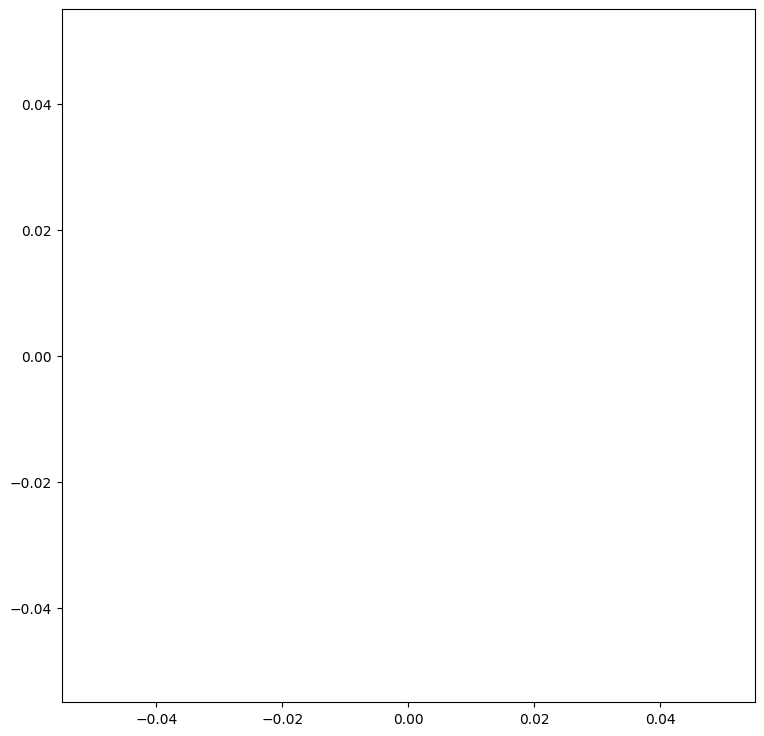

In [24]:
ax = gdf.plot(figsize=(9,9), edgecolor="black", column=gdf.index, categorical=True)
plt.show()



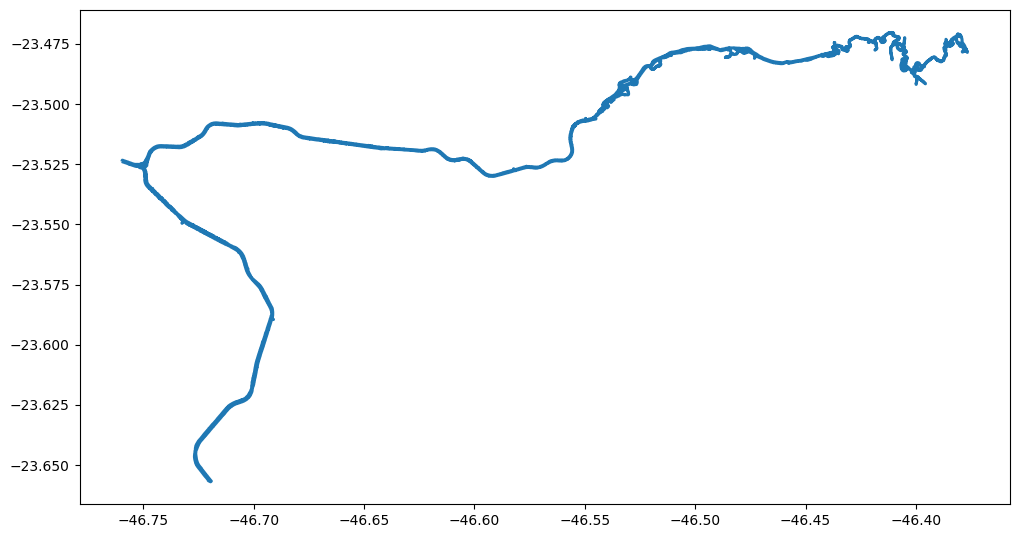

In [40]:
import numpy as np
import geopandas as gpd
import matplotlib.patheffects as pe
import matplotlib.patches as mpatches

# -------- 1) Garantir CRS compatível --------
# Se gdf_agua.crs for None, defina o CRS ORIGINAL do arquivo (não reprojeta!)
if gdf_agua.crs is None:
    # >>> só faça isso se tiver certeza do CRS original do arquivo de água
    # Ex.: SIRGAS 2000 / UTM 23S (São Paulo) -> "EPSG:31983"
    gdf_agua = gdf_agua.set_crs("EPSG:31983")

# Reprojetar água para o CRS do mapa
if gdf_agua.crs != gdf_resultado.crs:
    gdf_agua = gdf_agua.to_crs(gdf_resultado.crs)

# -------- 2) Filtrar Pinheiros e Tietê (tolerante a acento/maiúsculas) --------
def _normalize_series(s):
    s = s.astype(str)
    s = s.str.normalize("NFKD").str.encode("ascii", "ignore").str.decode("utf-8")
    return s.str.lower()

nome_norm = _normalize_series(gdf_agua["NOME"])
mask_pin  = nome_norm.str.contains(r"\bpinheiros\b", regex=True)
mask_tie  = nome_norm.str.contains(r"\btiete\b",    regex=True)

rios = gdf_agua.loc[mask_pin | mask_tie].copy()
rios["__nome__"] = np.where(mask_pin[mask_pin | mask_tie], "Pinheiros", "Tietê")

# Se vierem polígonos de massa d'água, usa só o contorno para parecer “rio”
if rios.geom_type.isin(["Polygon", "MultiPolygon"]).any():
    rios_line = rios.boundary
    rios = gpd.GeoDataFrame(rios.drop(columns="geometry"),
                            geometry=rios_line.values, crs=gdf_agua.crs)

# -------- 3) Recortar à área da cidade (opcional, para não “sobrar” fora) --------
#cidade = gdf_resultado.union_all()  # substitui unary_union (deprecated)
#rios = rios[rios.intersects(cidade)].copy()

# -------- 4) Plotar sobre o seu mapa (ax já existe) --------
fig, ax2 = plt.subplots(figsize=(12, 12))
# halo branco
rios.plot(ax=ax2, color="white", linewidth=4.0, zorder=7)
# cor dos rios (pode diferenciar se quiser)
cores = {"Pinheiros": "#1f78b4", "Tietê": "#1f78b4"}  # use cores diferentes se preferir
for nome, df_rio in rios.groupby("__nome__"):
    df_rio.plot(ax=ax2, color=cores.get(nome, "#1f78b4"), linewidth=2.2, zorder=8, label=nome)

# -------- 5) Rótulos no meio das linhas --------
#for _, row in rios.iterrows():
#    try:
#        p = row.geometry.interpolate(0.5, normalized=True)
#        ax.text(
#            p.x, p.y, row["__nome__"].upper(),
#            color=cores.get(row["__nome__"], "#1f78b4"), fontsize=9, weight="bold",
#            ha="center", va="center", zorder=9,
#            path_effects=[pe.withStroke(linewidth=2, foreground="white")]
#        )
#    except Exception:
#        pass

# -------- 6) Legenda compacta dos rios (se quiser separar das demais legendas) --------
#handles = [mpatches.Patch(facecolor="none", edgecolor=cores[k], label=k, linewidth=2.2)
#           for k in ["Pinheiros", "Tietê"] if (rios["__nome__"] == k).any()]
#if handles:
#    ax.legend(handles=handles, loc="upper left", fontsize=9, frameon=True, title="Rivers")

# pronto! os rios Pinheiros e Tietê ficam desenhados por cima do seu mapa



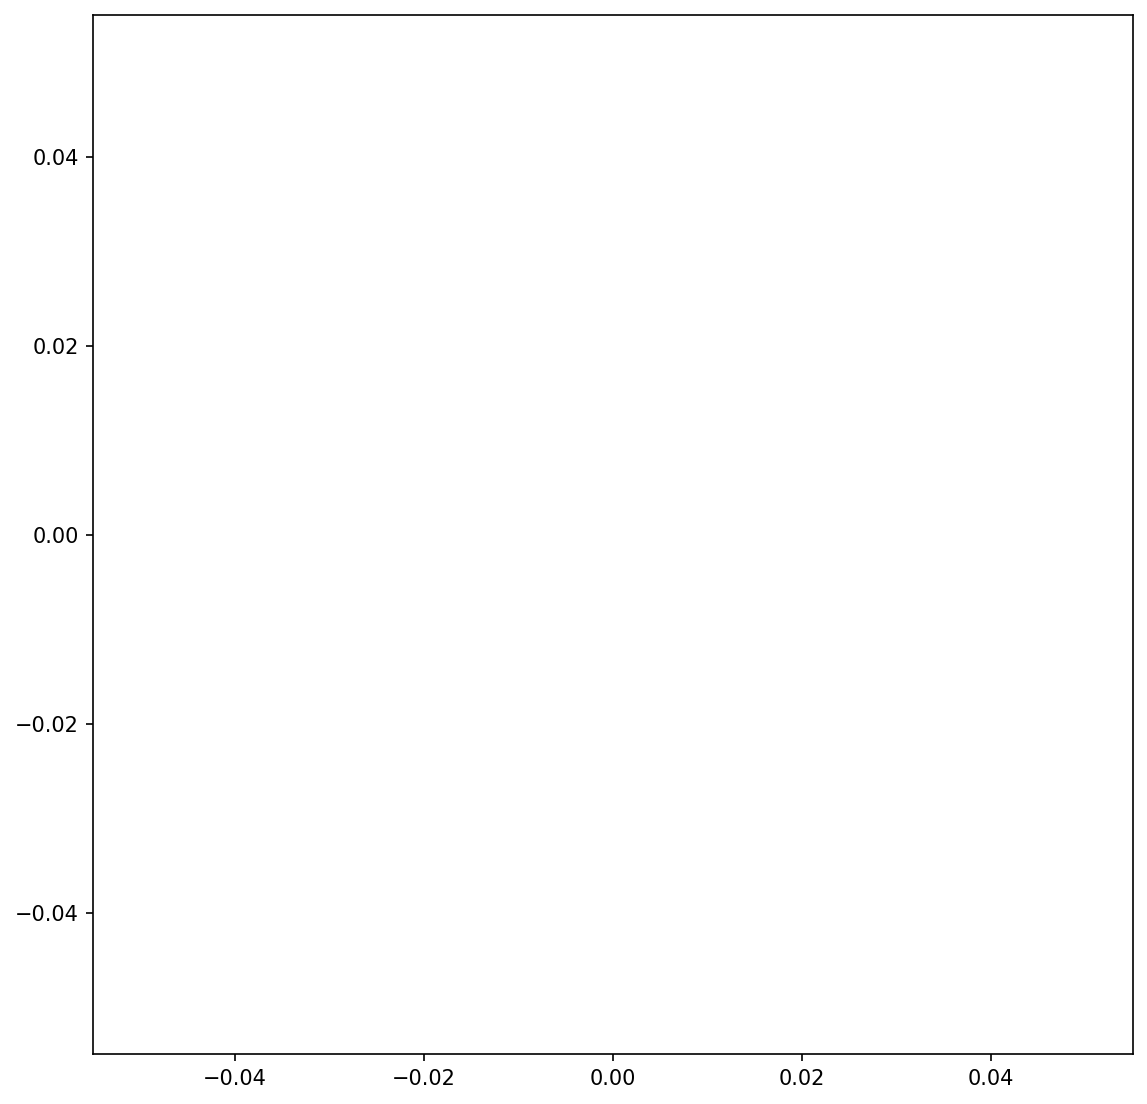

In [15]:
# -*- coding: utf-8 -*-
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib_scalebar.scalebar import ScaleBar
import unicodedata
import numpy as np
from pathlib import Path

# ------------------------------------------------------------
# 1) Carregar subprefeituras
# ------------------------------------------------------------
# Troque pelo caminho do seu arquivo .shp (ou .gpkg, .geojson etc.)
path_subpref = subprefeituras_shp  # ex.: r"/caminho/para/subprefeituras.shp"
gdf = gpd.read_file(path_subpref)

# ------------------------------------------------------------
# 2) Garantir CRS métrico (necessário p/ barra de escala)
#    UTM 23S cobre São Paulo. Ajuste se suas geometrias forem de outra região.
# ------------------------------------------------------------
if gdf.crs is None:
    # tente adivinhar WGS84 se vier sem CRS (ajuste se necessário)
    gdf = gdf.set_crs(4326, allow_override=True)

if gdf.crs.to_epsg() != 31983:
    gdf_utm = gdf.to_crs(31983)  # SIRGAS 2000 / UTM zone 23S (EPSG:31983)
else:
    gdf_utm = gdf.copy()

# ------------------------------------------------------------
# 3) Descobrir a coluna com o nome da subprefeitura
# ------------------------------------------------------------
possiveis_nomes = [
    "Subprefeitura", "subprefeitura", "SUBPREFEITURA",
    "nome", "NOME", "NM_SUBPREF", "NM_SUBPREFEITURA", "NM_SUBPREF_", "NM_SUBPREFEIT", "sp_nome"
]
col_nome = None
for c in gdf_utm.columns:
    if c in possiveis_nomes:
        col_nome = c
        break
if col_nome is None:
    # fallback: pega a primeira coluna de texto
    for c in gdf_utm.columns:
        if gdf_utm[c].dtype == object and c != "geometry":
            col_nome = c
            break
if col_nome is None:
    col_nome = "id"

# ------------------------------------------------------------
# 4) Função auxiliar para normalizar rótulos (sem acento, opcional)
# ------------------------------------------------------------
def sem_acento(s):
    if not isinstance(s, str):
        s = str(s)
    return "".join(
        ch for ch in unicodedata.normalize("NFD", s)
        if unicodedata.category(ch) != "Mn"
    )

# ------------------------------------------------------------
# 5) Plot
# ------------------------------------------------------------
fig, ax2 = plt.subplots(figsize=(9, 9), dpi=150)

# desenha polígonos (face sem preenchimento e linha fina)
gdf_utm.plot(ax=ax2, facecolor="none", edgecolor="0.2", linewidth=0.8)

# rótulos no centróide (usa label sem acento para reduzir sobreposição visual)
centroids = gdf_utm.geometry.representative_point()
for xy, nome in zip(centroids, gdf_utm[col_nome].astype(str)):
    ax.text(
        xy.x, xy.y, sem_acento(nome),
        fontsize=7.5, ha="center", va="center",
        path_effects=[pe.withStroke(linewidth=2.2, foreground="white", alpha=0.85)]
    )

# barra de escala (unidades derivadas do CRS métrico)
scalebar = ScaleBar(
    dx=1,  # 1 unidade do CRS = 1 metro no EPSG:31983
    units="m",
    dimension="si-length",
    location="lower left",
    box_alpha=0.9,
    frameon=True
)
ax.add_artist(scalebar)

# seta do norte (simples)
def add_north_arrow(ax, size=7000, pad=3000):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x = xlim[1] - size - pad
    y = ylim[1] - size - pad
    ax.annotate(
        "N",
        xy=(x + size/2, y + size*0.9),
        xytext=(x + size/2, y + size*0.2),
        arrowprops=dict(arrowstyle="-|>", lw=1.2),
        ha="center", va="center", fontsize=10, fontweight="bold"
    )

add_north_arrow(ax)

# estética básica
ax.set_aspect("equal")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Subprefeituras — São Paulo", loc="left", fontsize=11, pad=10)
ax.set_xticks([])
ax.set_yticks([])
ax.margins(0.02)

# salvar figura
#out_path = Path("mapa_subprefeituras.png")
#plt.savefig(out_path, bbox_inches="tight", pad_inches=0.5)
plt.show()


<Axes: >

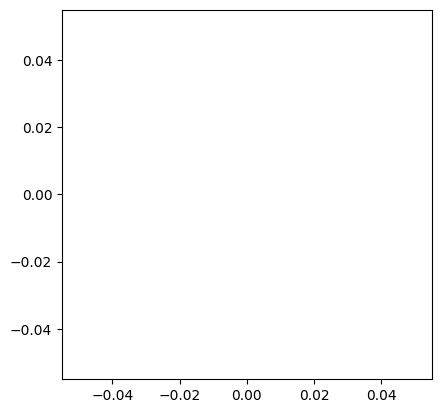

In [17]:
gdf_utm.plot(facecolor="none", edgecolor="0.2", linewidth=0.8)


### Visualização das datas

In [10]:
arquivo_pacotes = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/My Drive/pacotes.simul_2023_1120.xls'

In [14]:
# Ler a planilha usando o engine xlrd (necessário para arquivos .xls)
df_real = pd.read_excel(arquivo_pacotes, sheet_name="pacotes.simul_2023_1120", engine="xlrd")

col_data = 'Data evento'  # Nome da coluna com a data do pacote
col_tipo = 'Tipo'  # Nome da coluna que indica se é 'Detalhado' ou 'Inteiro'

# Garantir formato datetime
df_real[col_data] = pd.to_datetime(df_real[col_data], errors='coerce')
df_real = df_real.dropna(subset=[col_data, col_tipo])

# 1. Garantir que a coluna de datas está em datetime
df_real["Data evento"] = pd.to_datetime(df_real["Data evento"], errors="coerce")

# 2. Filtrar apenas os meses desejados
df_real = df_real[
    df_real["Data evento"].dt.month.isin([1, 2, 3]) &
    (df_real["Data evento"].dt.year == 2023)
]

# 3. Mapear os tipos para códigos numéricos
tipo_to_codigo = {"Detalhado": 1, "Inteiro": 2}
flood_data_real = {
    row["Data evento"].date(): tipo_to_codigo.get(row["Tipo"], 0)
    for _, row in df_real.iterrows()
}

# 4. Atualizar o DataFrame de calendário com os dados reais
df_calendar["flood_code"] = df_calendar["date"].dt.date.map(flood_data_real).fillna(0).astype(int)

# Regerar o gráfico final com os dados reais integrados
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, month in enumerate(months):
    ax = axes[i]
    month_df = df_calendar[df_calendar["month"] == month]

    # Pivot com preenchimento para alinhar altura
    pivot = pd.pivot_table(
        month_df,
        index="week",
        columns="weekday",
        values="flood_code",
        aggfunc="first",
        fill_value=np.nan
    )
    day_pivot = pd.pivot_table(
        month_df,
        index="week",
        columns="weekday",
        values="day",
        aggfunc="first",
        fill_value=np.nan
    )

    # Padding para igualar alturas
    while pivot.shape[0] < max_weeks:
        empty_row = pd.Series([np.nan] * 7, index=pivot.columns, name=pivot.index.max() + 1)
        pivot = pd.concat([pivot, empty_row.to_frame().T])
        day_pivot = pd.concat([day_pivot, empty_row.to_frame().T])

    cmap = matplotlib.colormaps.get_cmap("OrRd").resampled(3)
    im = ax.imshow(pivot, cmap=cmap, vmin=0, vmax=2)

    ax.set_title(
        f'{month_names_pt[month]} 2023',
        fontsize=16,
        fontweight='bold',
        loc='center',
        pad=15
    )

    ax.set_xticks(range(7))
    ax.set_xticklabels(["S", "T", "Q", "Q", "S", "S", "D"])
    ax.set_yticks([])

    for y in range(pivot.shape[0]):
        for x in range(pivot.shape[1]):
            day_num = day_pivot.iloc[y, x]
            if not np.isnan(day_num):
                ax.text(x, y, str(int(day_num)), va='center', ha='center', fontsize=13, color='black')

    for edge in ["top", "right", "left", "bottom"]:
        ax.spines[edge].set_visible(False)

# Legenda
legend_elements = [
    Patch(facecolor=cmap(0), label="Sem alagamento"),
    Patch(facecolor=cmap(1), label="Simulação detalhada"),
    Patch(facecolor=cmap(2), label="Simulação inteira"),
]
fig.legend(handles=legend_elements, loc="upper center", ncol=3, 
    bbox_to_anchor=(0.5, 1.08),
    fontsize=13)

#fig.suptitle("Alagamentos em Jan-Mar 2023", fontsize=16)
plt.tight_layout()
plt.show()


NameError: name 'df_calendar' is not defined

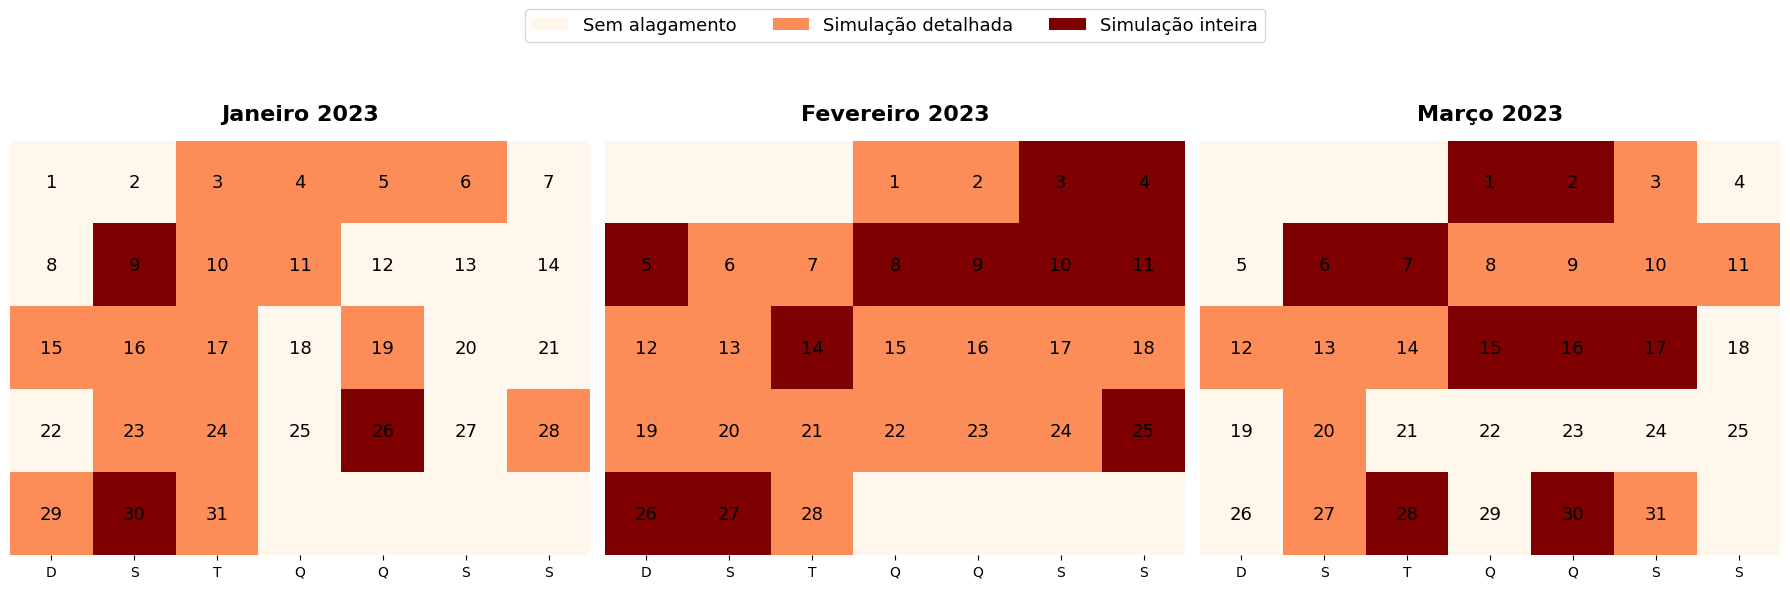

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib
import calendar

# Ler planilha
df_real = pd.read_excel(arquivo_pacotes, sheet_name="pacotes.simul_2023_1120", engine="xlrd")

# Garantir datetime e remover nulos
df_real["Data evento"] = pd.to_datetime(df_real["Data evento"], errors='coerce')
df_real = df_real.dropna(subset=["Data evento", "Tipo"])

# Filtrar apenas jan, fev, mar de 2023
df_real = df_real[
    (df_real["Data evento"].dt.year == 2023) &
    (df_real["Data evento"].dt.month.isin([1, 2, 3]))
]

# Mapeamento de tipo
tipo_to_codigo = {"Detalhado": 1, "Inteiro": 2}
flood_data_real = {
    row["Data evento"].date(): tipo_to_codigo.get(row["Tipo"], 0)
    for _, row in df_real.iterrows()
}

# Parâmetros para plotagem
months = [1, 2, 3]
month_names_pt = {1: "Janeiro", 2: "Fevereiro", 3: "Março"}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, month in enumerate(months):
    ax = axes[i]

    # Obter matriz de dias do calendário (semana x dia da semana)
    cal = calendar.Calendar(firstweekday=6)  # domingo = 0
    cal_matrix = cal.monthdayscalendar(2023, month)
    cal_matrix = np.array(cal_matrix)

    # Criar matriz de códigos (igual à matriz de dias)
    code_matrix = np.zeros_like(cal_matrix)

    for week_idx, week in enumerate(cal_matrix):
        for day_idx, day in enumerate(week):
            if day != 0:  # dia válido do mês
                date_obj = pd.Timestamp(year=2023, month=month, day=day).date()
                code_matrix[week_idx, day_idx] = flood_data_real.get(date_obj, 0)

    # Plotar imagem
    cmap = matplotlib.colormaps.get_cmap("OrRd").resampled(3)
    im = ax.imshow(code_matrix, cmap=cmap, vmin=0, vmax=2)

    # Título do mês
    ax.set_title(
        f"{month_names_pt[month]} 2023",
        fontsize=16,
        fontweight='bold',
        loc='center',
        pad=15
    )

    # Eixos e labels
    ax.set_xticks(range(7))
    ax.set_xticklabels(["D", "S", "T", "Q", "Q", "S", "S"])  # Domingo primeiro
    ax.set_yticks([])

    # Inserir números dos dias
    for y in range(cal_matrix.shape[0]):
        for x in range(cal_matrix.shape[1]):
            day = cal_matrix[y, x]
            if day != 0:
                ax.text(x, y, str(day), va='center', ha='center', fontsize=13, color='black')

    # Remover bordas
    for edge in ["top", "right", "left", "bottom"]:
        ax.spines[edge].set_visible(False)

# Legenda
legend_elements = [
    Patch(facecolor=cmap(0), label="Sem alagamento"),
    Patch(facecolor=cmap(1), label="Simulação detalhada"),
    Patch(facecolor=cmap(2), label="Simulação inteira"),
]
fig.legend(handles=legend_elements, loc="upper center", ncol=3, 
    bbox_to_anchor=(0.5, 1.08),
    fontsize=13)

plt.tight_layout()
plt.show()



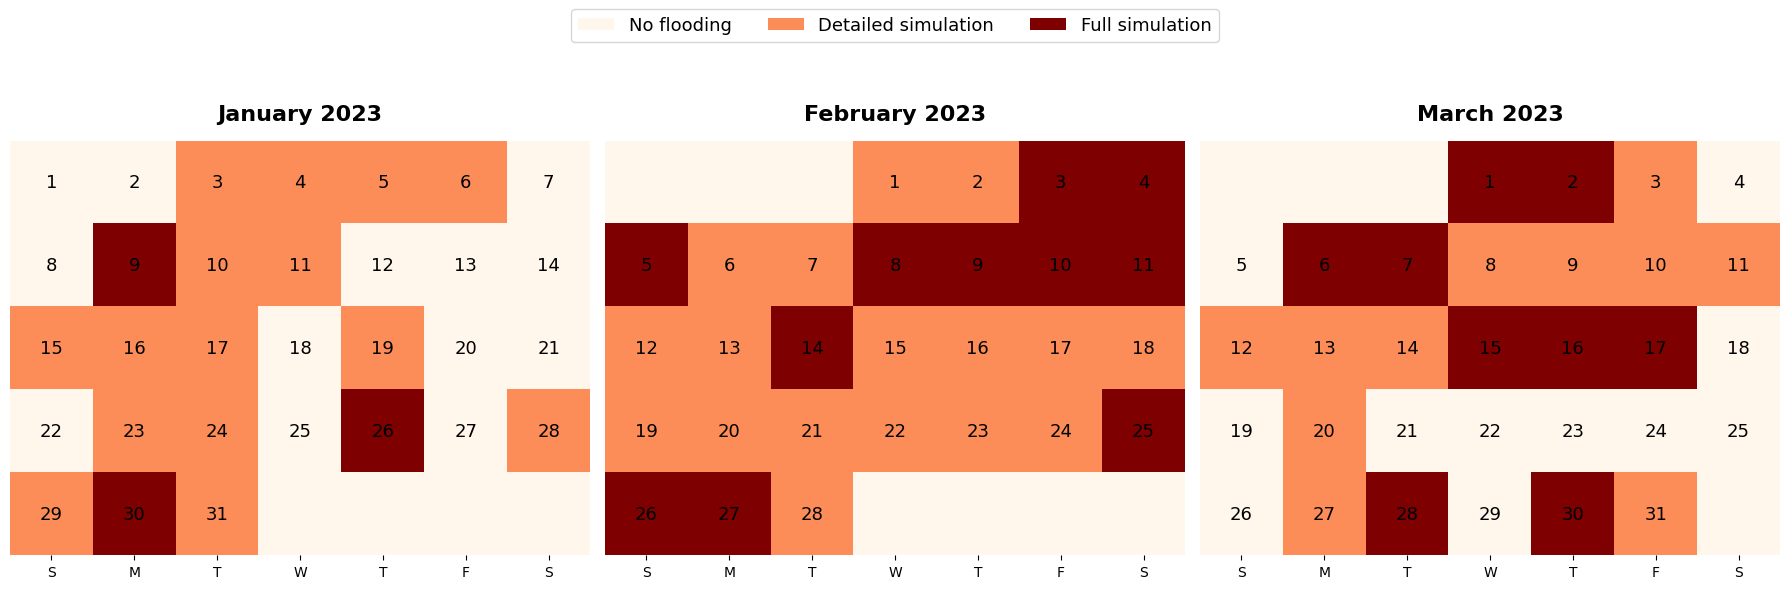

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib
import calendar

# Ler planilha
df_real = pd.read_excel(arquivo_pacotes, sheet_name="pacotes.simul_2023_1120", engine="xlrd")

# Garantir datetime e remover nulos
df_real["Data evento"] = pd.to_datetime(df_real["Data evento"], errors='coerce')
df_real = df_real.dropna(subset=["Data evento", "Tipo"])

# Filtrar apenas jan, fev, mar de 2023
df_real = df_real[
    (df_real["Data evento"].dt.year == 2023) &
    (df_real["Data evento"].dt.month.isin([1, 2, 3]))
]

# Mapeamento de tipo
tipo_to_codigo = {"Detalhado": 1, "Inteiro": 2}
flood_data_real = {
    row["Data evento"].date(): tipo_to_codigo.get(row["Tipo"], 0)
    for _, row in df_real.iterrows()
}

# Parâmetros para plotagem
months = [1, 2, 3]
month_names_pt = {1: "January", 2: "February", 3: "March"}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, month in enumerate(months):
    ax = axes[i]

    # Obter matriz de dias do calendário (semana x dia da semana)
    cal = calendar.Calendar(firstweekday=6)  # domingo = 0
    cal_matrix = cal.monthdayscalendar(2023, month)
    cal_matrix = np.array(cal_matrix)

    # Criar matriz de códigos (igual à matriz de dias)
    code_matrix = np.zeros_like(cal_matrix)

    for week_idx, week in enumerate(cal_matrix):
        for day_idx, day in enumerate(week):
            if day != 0:  # dia válido do mês
                date_obj = pd.Timestamp(year=2023, month=month, day=day).date()
                code_matrix[week_idx, day_idx] = flood_data_real.get(date_obj, 0)

    # Plotar imagem
    cmap = matplotlib.colormaps.get_cmap("OrRd").resampled(3)
    im = ax.imshow(code_matrix, cmap=cmap, vmin=0, vmax=2)

    # Título do mês
    ax.set_title(
        f"{month_names_pt[month]} 2023",
        fontsize=16,
        fontweight='bold',
        loc='center',
        pad=15
    )

    # Eixos e labels
    ax.set_xticks(range(7))
    ax.set_xticklabels(["S", "M", "T", "W", "T", "F", "S"])  # Domingo primeiro
    ax.set_yticks([])

    # Inserir números dos dias
    for y in range(cal_matrix.shape[0]):
        for x in range(cal_matrix.shape[1]):
            day = cal_matrix[y, x]
            if day != 0:
                ax.text(x, y, str(day), va='center', ha='center', fontsize=13, color='black')

    # Remover bordas
    for edge in ["top", "right", "left", "bottom"]:
        ax.spines[edge].set_visible(False)

# Legenda
legend_elements = [
    Patch(facecolor=cmap(0), label="No flooding"),
    Patch(facecolor=cmap(1), label="Detailed simulation"),
    Patch(facecolor=cmap(2), label="Full simulation"),
]
fig.legend(handles=legend_elements, loc="upper center", ncol=3, 
    bbox_to_anchor=(0.5, 1.08),
    fontsize=13)

plt.tight_layout()
plt.show()



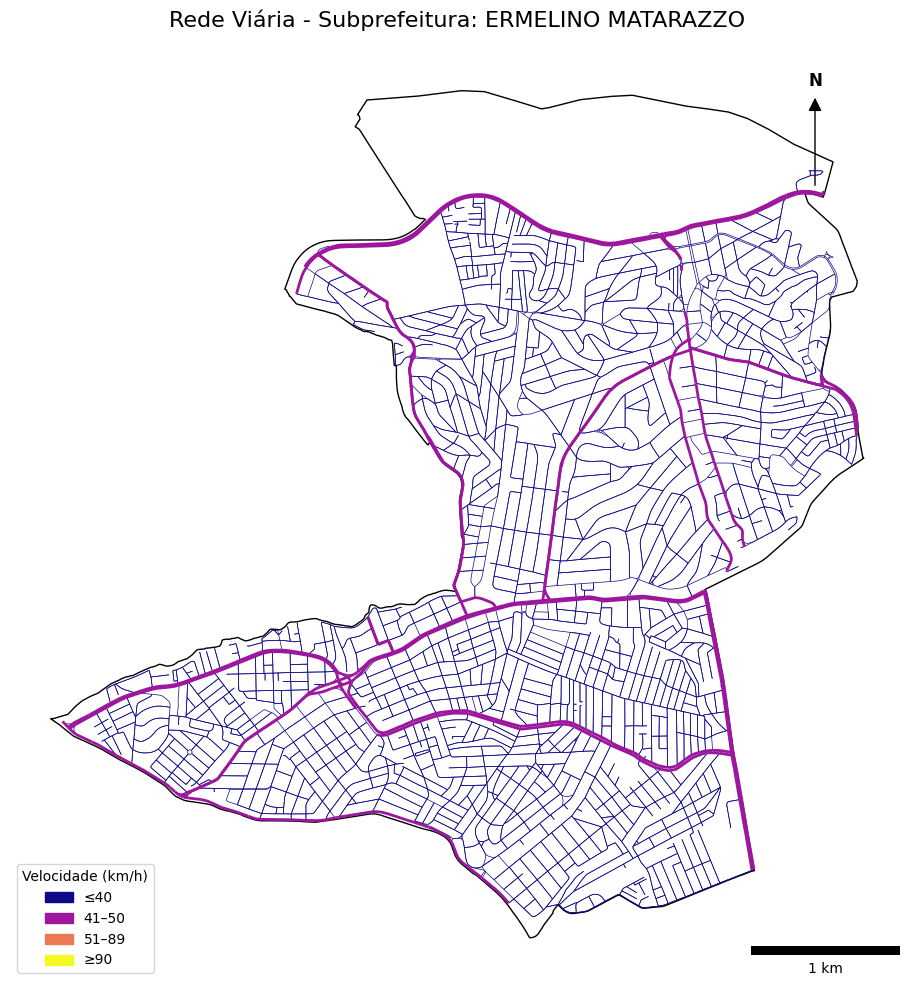

In [8]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib

# Parâmetros
nome_sub = 'ERMELINO MATARAZZO'

# Dados
gdf_subpref = gpd.read_file(subprefeituras_shp).set_crs("EPSG:31983")
gdf_sub = gdf_subpref[gdf_subpref['sp_nome'] == nome_sub]
gdf_sub_wgs84 = gdf_sub.to_crs("EPSG:4326")
poly_wgs84 = gdf_sub_wgs84.geometry.iloc[0]

# Rede viária
G = ox.graph_from_polygon(poly_wgs84, network_type="drive")
G = ox.add_edge_speeds(G, fallback=30)
nodes, edges = ox.graph_to_gdfs(G)
edges = edges.to_crs("EPSG:31983")

bins = [0, 40, 50, 89, float('inf')]
labels = ['≤40', '41–50', '51–89', '≥90']

edges['vel_classe'] = pd.cut(
    edges['speed_kph'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

espessuras = {
    '≤40': 0.5,
    '41–50': 2,
    '51–89': 2.5,
    '≥90': 3.5
}

# Criar cores automaticamente de um colormap
cmap = matplotlib.colormaps.get_cmap('plasma').resampled(len(labels))
cores = {label: cmap(i) for i, label in enumerate(labels)}

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_sub.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)

for classe, cor in cores.items():
    subset = edges[edges['vel_classe'] == classe]
    if subset.empty:
        continue  # pula a classe vazia
    lw = espessuras.get(classe, 1)  # usa 1 como padrão se não encontrado
    subset.plot(ax=ax, color=cor, linewidth=lw, label=classe)

# Legenda manual
handles = [mpatches.Patch(color=cor, label=classe) for classe, cor in cores.items()]
leg = ax.legend(handles=handles, title="Velocidade (km/h)", loc='lower left', frameon=True)
leg.get_title().set_fontsize(10)

# Escala
scalebar = ScaleBar(dx=1, units="m", location="lower right")
ax.add_artist(scalebar)

# Seta de norte no canto superior direito
arrow = mpatches.FancyArrowPatch((0.9, 0.85), (0.9, 0.95), transform=ax.transAxes,
                                  color='black', arrowstyle='-|>', mutation_scale=20)
ax.add_patch(arrow)
ax.text(0.9, 0.955, 'N', transform=ax.transAxes, ha='center', va='bottom',
        fontsize=12, fontweight='bold')

# Layout
ax.set_title(f"Rede Viária - Subprefeitura: {nome_sub}", fontsize=16, pad=15)
ax.set_axis_off()
plt.tight_layout()

# Exportar
plt.savefig(f"mapa_rede_viaria_{nome_sub.lower()}.png", dpi=300)
plt.show()


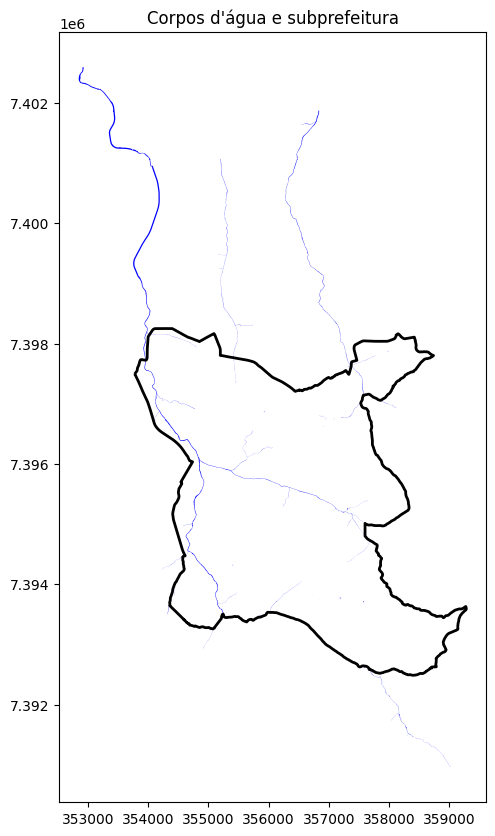

In [ ]:
import matplotlib.pyplot as plt

# Força o CRS apenas se tiver certeza de que o shapefile está em EPSG:31983
gdf_agua = gpd.read_file(massa_agua)
gdf_agua.set_crs("EPSG:31983", inplace=True)  # <- Define o CRS, não transforma

# Agora você pode converter (se necessário)
gdf_agua = gdf_agua.to_crs("EPSG:31983")  # Este passo é redundante se já está no CRS certo

# Certifique-se de que ambos estão no mesmo CRS
gdf_agua = gdf_agua.to_crs("EPSG:31983")
gdf_sub = gdf_sub.to_crs("EPSG:31983")

# Pega o polígono da subprefeitura
poligono = gdf_sub.geometry.iloc[0]

# Filtra os corpos d'água que estão dentro do polígono
gdf_agua_filtrado = gdf_agua[gdf_agua.geometry.intersects(poligono)]

fig, ax = plt.subplots(figsize=(10, 10))
gdf_sub.boundary.plot(ax=ax, color='black', linewidth=2)
gdf_agua_filtrado.plot(ax=ax, color='blue')
plt.title("Corpos d'água e subprefeitura")
plt.show()


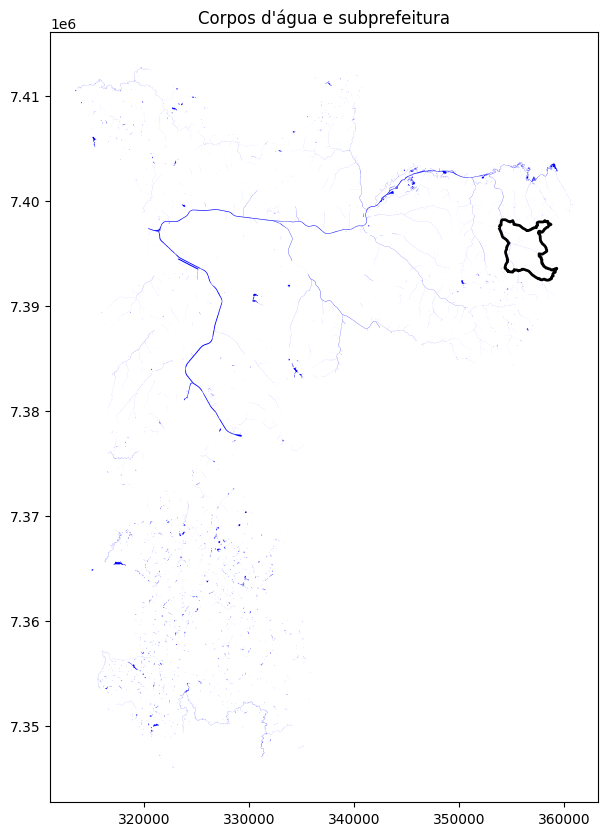

In [ ]:


fig, ax = plt.subplots(figsize=(10, 10))
gdf_sub.boundary.plot(ax=ax, color='black', linewidth=2)
gdf_agua.plot(ax=ax, color='blue')
plt.title("Corpos d'água e subprefeitura")
plt.show()


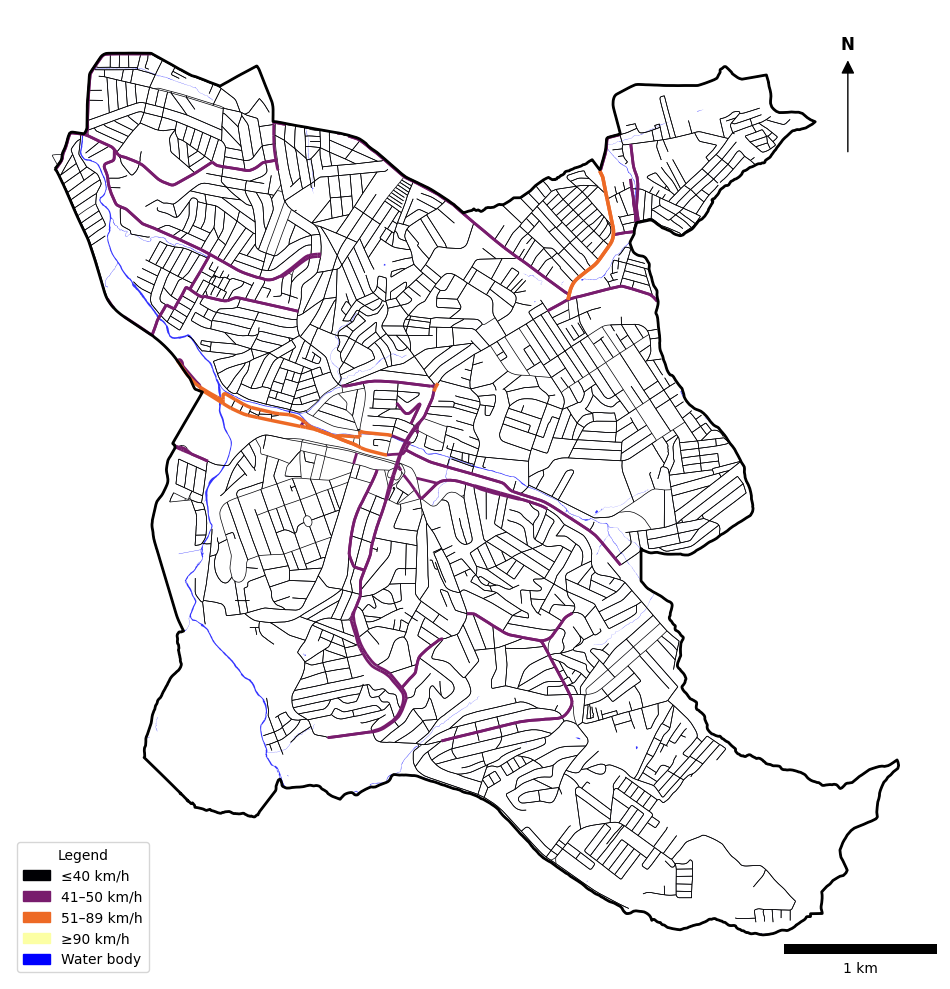

In [6]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib
from geopandas import clip

# Parâmetros
nome_sub = 'GUAIANASES'

# --- Dados de subprefeitura ---
gdf_subpref = gpd.read_file(subprefeituras_shp).set_crs("EPSG:31983")
gdf_sub = gdf_subpref[gdf_subpref['sp_nome'] == nome_sub]
gdf_sub_wgs84 = gdf_sub.to_crs("EPSG:4326")
poly_wgs84 = gdf_sub_wgs84.geometry.iloc[0]

# --- Rede viária ---
G = ox.graph_from_polygon(poly_wgs84, network_type="drive")
G = ox.add_edge_speeds(G, fallback=30)
nodes, edges = ox.graph_to_gdfs(G)
edges = edges.to_crs("EPSG:31983")

# Classificação de velocidade
bins = [0, 40, 50, 89, float('inf')]
labels = ['≤40 km/h', '41–50 km/h', '51–89 km/h', '≥90 km/h']
edges['vel_classe'] = pd.cut(edges['speed_kph'], bins=bins, labels=labels, include_lowest=True)

espessuras = {'≤40 km/h': 0.5, '41–50 km/h': 2, '51–89 km/h': 2.5, '≥90 km/h': 3.5}
cmap = matplotlib.colormaps.get_cmap('inferno').resampled(len(labels))
cores = {label: cmap(i) for i, label in enumerate(labels)}

# --- Corpos d'água ---
gdf_agua = gpd.read_file(massa_agua)
gdf_agua.set_crs("EPSG:31983", inplace=True)  # Define CRS se não existir
gdf_agua = gdf_agua.to_crs("EPSG:31983")
#gdf_agua_filtrado = gdf_agua[gdf_agua.geometry.intersects(gdf_sub.geometry.iloc[0])]
gdf_agua_filtrado = gpd.clip(gdf_agua, gdf_sub)

# --- Plotagem combinada ---
fig, ax = plt.subplots(figsize=(10, 10))

# Subprefeitura
gdf_sub.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
gdf_sub.boundary.plot(ax=ax, edgecolor='black', linewidth=2, zorder=3)


# Corpos d’água
# gdf_agua_filtrado.plot(ax=ax, color='blue', linewidth=1, alpha=0.8, label='Corpos d\'água')

# Ex: rios maiores com espessura maior
for idx, row in gdf_agua_filtrado.iterrows():
    lw = 1.5 if row.get('waterway') == 'river' else 0.8
    gpd.GeoSeries([row.geometry]).plot(ax=ax, color='blue', linewidth=lw, alpha=0.8)


# Rede viária
for classe, cor in cores.items():
    subset = edges[edges['vel_classe'] == classe]
    if subset.empty:
        continue
    lw = espessuras.get(classe, 1)
    subset.plot(ax=ax, color=cor, linewidth=lw, label=classe)

# Legenda
handles = [mpatches.Patch(color=cor, label=classe) for classe, cor in cores.items()]
handles.append(mpatches.Patch(color='blue', label="Water body"))
leg = ax.legend(handles=handles, title="Legend", loc='lower left', frameon=True)
leg.get_title().set_fontsize(10)

# Escala
scalebar = ScaleBar(dx=1, units="m", location="lower right")
ax.add_artist(scalebar)

# Norte
arrow = mpatches.FancyArrowPatch((0.9, 0.85), (0.9, 0.95), transform=ax.transAxes,
                                  color='black', arrowstyle='-|>', mutation_scale=20)
ax.add_patch(arrow)
ax.text(0.9, 0.955, 'N', transform=ax.transAxes, ha='center', va='bottom',
        fontsize=12, fontweight='bold')

# Layout final
#ax.set_title(f"Rede Viária e Corpos d'Água - Subprefeitura: {nome_sub}", fontsize=16, pad=15)
ax.set_axis_off()
plt.tight_layout()
plt.savefig(f"mapa_viario_agua_{nome_sub.lower()}.png", dpi=300)
plt.show()


### Produção de mapas para apresentação da dissertação de mestrado

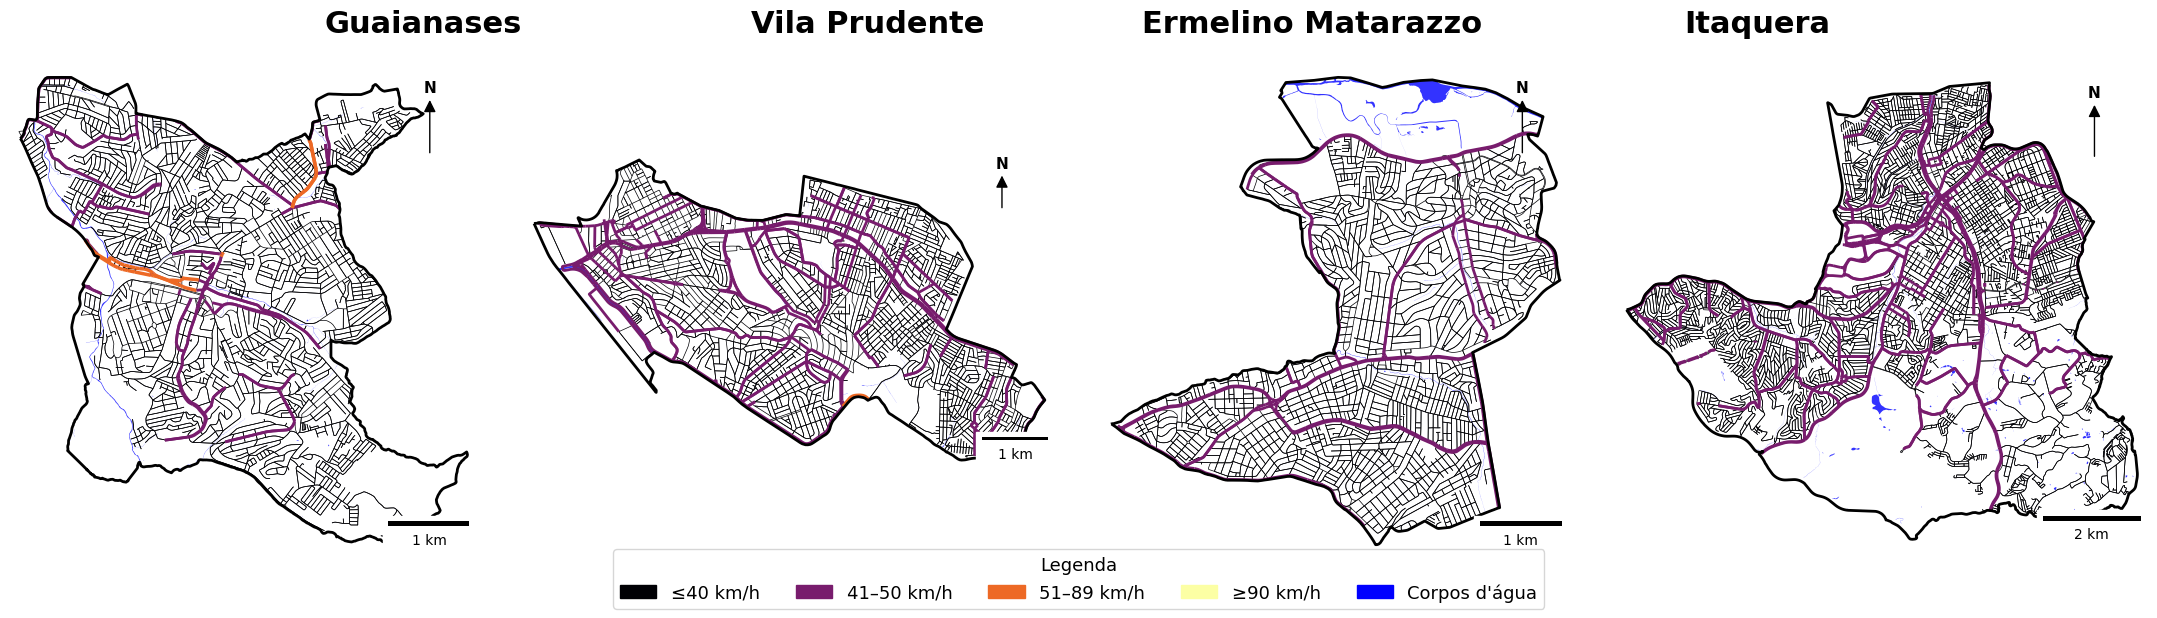

In [21]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
import pandas as pd
import matplotlib
from shapely.geometry import Polygon

# ----------------------------
# Parâmetros
# ----------------------------
SUBS = ['GUAIANASES', 'VILA PRUDENTE', 'ERMELINO MATARAZZO', 'ITAQUERA']
crs_metros = "EPSG:31983"
crs_wgs84 = "EPSG:4326"

# Classes de velocidade
bins = [0, 40, 50, 89, float('inf')]
labels = ['≤40 km/h', '41–50 km/h', '51–89 km/h', '≥90 km/h']
cmap = matplotlib.colormaps.get_cmap('inferno').resampled(len(labels))
cores = {label: cmap(i) for i, label in enumerate(labels)}
espessuras = {'≤40 km/h': 0.5, '41–50 km/h': 2, '51–89 km/h': 2.5, '≥90 km/h': 3.5}

# ----------------------------
# Utilitário de CRS
# ----------------------------
def to_crs_safe(gdf, target_crs, assume_if_none=None):
    if gdf.crs is None:
        if assume_if_none is None:
            raise ValueError("GeoDataFrame sem CRS e 'assume_if_none' não informado.")
        gdf = gdf.set_crs(assume_if_none)
    return gdf.to_crs(target_crs)

# ----------------------------
# Dados base
# ----------------------------
gdf_subpref = gpd.read_file(subprefeituras_shp)
gdf_subpref = to_crs_safe(gdf_subpref, crs_metros, assume_if_none=crs_metros)
gdf_subpref['sp_nome_up'] = gdf_subpref['sp_nome'].str.upper()

gdf_agua = gpd.read_file(massa_agua)
gdf_agua = to_crs_safe(gdf_agua, crs_metros, assume_if_none=crs_metros)

# ----------------------------
# Desenho por painel
# ----------------------------
def desenhar_sub(ax, gsub_row):
    geom_m = gsub_row.geometry
    geom_wgs = gpd.GeoSeries([geom_m], crs=crs_metros).to_crs(crs_wgs84).iloc[0]

    # Grafo OSM
    poly_wgs84 = geom_wgs if isinstance(geom_wgs, Polygon) else geom_wgs.convex_hull
    G = ox.graph_from_polygon(poly_wgs84, network_type="drive")
    G = ox.add_edge_speeds(G, fallback=30)
    _, edges = ox.graph_to_gdfs(G)
    edges = edges.to_crs(crs_metros)

    # Classificação
    edges['vel_classe'] = pd.cut(edges['speed_kph'], bins=bins, labels=labels, include_lowest=True)

    # Água (clip)
    gdf_agua_clip = gpd.clip(gdf_agua, gpd.GeoSeries([geom_m], crs=crs_metros))
    if not gdf_agua_clip.empty:
        gdf_agua_clip.plot(ax=ax, color='blue', linewidth=1, alpha=0.8)

    # Rede viária
    for classe, cor in cores.items():
        subset = edges[edges['vel_classe'] == classe]
        if not subset.empty:
            subset.plot(ax=ax, color=cor, linewidth=espessuras.get(classe, 1))

    # Contorno
    gpd.GeoSeries([geom_m], crs=crs_metros).boundary.plot(ax=ax, edgecolor='black', linewidth=2, zorder=3)

    # Margem para evitar encostar
    ax.margins(0.02, 0.02)

    # Escala (com padding)
    ax.add_artist(ScaleBar(dx=1, units="m", location="lower right", pad=0.4))

    # Norte
    arrow = mpatches.FancyArrowPatch((0.90, 0.82), (0.90, 0.94),
                                     transform=ax.transAxes, color='black',
                                     arrowstyle='-|>', mutation_scale=18)
    ax.add_patch(arrow)
    ax.text(0.90, 0.945, 'N', transform=ax.transAxes,
            ha='center', va='bottom', fontsize=11, fontweight='bold')

    # Remover eixos/moldura de forma forçada
    ax.set_axis_off()
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

# ----------------------------
# Figura 1×4
# ----------------------------
fig, axes = plt.subplots(1, 4, figsize=(22, 6))

for ax, nome_sub in zip(axes, SUBS):
    match = gdf_subpref[gdf_subpref['sp_nome_up'] == nome_sub.upper()]
    if match.empty:
        ax.set_axis_off()
        continue
    desenhar_sub(ax, match.iloc[0])

# ----------------------------
# Títulos centralizados sobre o MAPA (não o eixo)
# ----------------------------
title_y = 0.965  # altura única dos títulos
for ax, nome_sub in zip(axes, SUBS):
    # centro do conteúdo em coordenadas de dados
    x0, x1 = ax.get_xlim()
    x_center_data = 0.5 * (x0 + x1)
    # converte X de dados -> coords da figura
    x_disp = ax.transData.transform((x_center_data, 0))[0]
    x_fig = fig.transFigure.inverted().transform((x_disp, 0))[0]
    fig.text(x_fig, title_y, nome_sub.title(),
             ha='center', va='bottom', fontsize=22, fontweight='bold')

# ----------------------------
# Legenda única
# ----------------------------
handles = [mpatches.Patch(color=cores[l], label=l) for l in labels]
handles.append(mpatches.Patch(color='blue', label="Corpos d'água"))
leg = fig.legend(handles=handles, title="Legenda",
                 loc='lower center', ncol=5, frameon=True, fontsize=13)
leg.get_title().set_fontsize(13)

# espaço para títulos e legenda
plt.tight_layout(rect=[0, 0.08, 1, 0.94])

#plt.savefig("mapa_viario_agua_1x4.png", dpi=300, bbox_inches='tight')
plt.show()


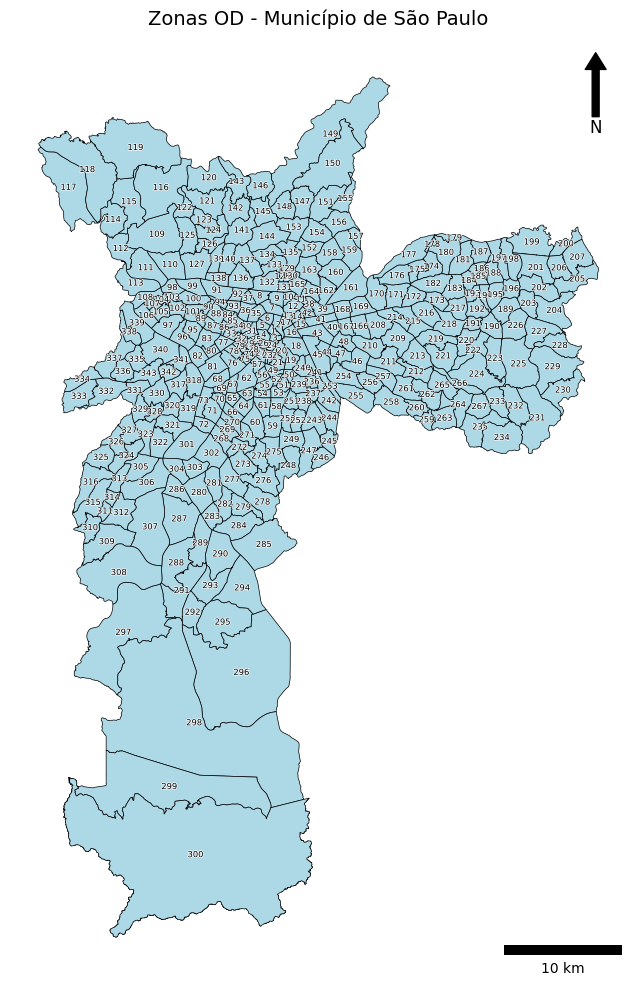

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patheffects as path_effects

# 1. Carregar shapefile
gpd_OD_2023 = gpd.read_file(zonas_shp_OD_2023)

# 2. Filtrar para o município de São Paulo
gdf_sp = gpd_OD_2023[gpd_OD_2023['NomeMunici'].str.upper() == 'SÃO PAULO'].copy()

# 3. Reprojetar para EPSG:31983 (SIRGAS 2000 / UTM zone 23S)
gdf_sp = gdf_sp.to_crs(epsg=31983)

# 4. Plotar com número da zona
fig, ax = plt.subplots(figsize=(12, 10))
gdf_sp.plot(ax=ax, edgecolor='black', facecolor='lightblue', linewidth=0.5)

# Adicionar rótulos no centroide
for idx, row in gdf_sp.iterrows():
    centroid = row['geometry'].centroid
    text = ax.text(centroid.x, centroid.y, str(row['NumeroZona']),
                   fontsize=6, ha='center', va='center', color='black')
    text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='white'), path_effects.Normal()])

# 5. Adicionar escala gráfica
scalebar = ScaleBar(1, location='lower right', units='m', dimension='si-length')  # 1 unit = 1 meter
ax.add_artist(scalebar)

# 6. Adicionar seta de norte
x, y, dx, dy = 0.95, 0.9, 0, 0.08  # posição relativa (em axes fraction)
ax.annotate('N', xy=(x, y+dy), xytext=(x, y),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=12, xycoords=ax.transAxes)

# Ajustes finais
ax.set_title('Zonas OD - Município de São Paulo', fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


### Images in English for Journal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.patheffects as path_effects
import pandas as pd

# Exemplo de listas (substitua pelas suas reais)
# subprefeituras_plot, medianas, amplitudes, impactos_medios devem já estar definidos

# Normalização por mediana
norm = Normalize(vmin=min(medianas), vmax=max(medianas))
cmap = plt.cm.inferno
colors = cmap(norm(medianas))

# Criar figura
fig, ax = plt.subplots(figsize=(14, 8))
scatter = ax.scatter(medianas, amplitudes, s=impactos_medios,
                     c=colors, alpha=0.8, linewidths=0)

# Barra de cor
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Mediana da Resiliência')

# Linhas dos quadrantes
media_mediana = np.mean(medianas)
media_amplitude = np.mean(amplitudes)
ax.axvline(media_mediana, color='red', linestyle='--', linewidth=2)
ax.axhline(media_amplitude, color='red', linestyle='--', linewidth=2)

# Títulos dos quadrantes (coordenadas fixas para sempre aparecerem)
ax.text(0.28, 0.58, "LH", fontsize=12, color='red', ha='center')
ax.text(0.28, 0.03, "LL", fontsize=12, color='red', ha='center')
ax.text(0.95, 0.58, "HH", fontsize=12, color='red', ha='center')
ax.text(0.95, 0.03, "HL", fontsize=12, color='red', ha='center')

# Números centralizados nas bolhas
for i, nome in enumerate(subprefeituras_plot):
    rgb = colors[i][:3]
    luminancia = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
    cor_texto = 'black' if luminancia > 0.55 else 'white'

    ax.text(
        medianas[i],
        amplitudes[i],
        f"{i+1}",
        fontsize=10,
        ha='center',
        va='center',
        color=cor_texto,
        zorder=10,
        path_effects=[
            path_effects.Stroke(linewidth=1.3, foreground='white'),
            path_effects.Normal()
        ]
    )

# Título e labels
ax.set_title("Resiliência por Subprefeitura – Impacto Médio no Tamanho da Bolha", fontsize=16, weight='bold')
ax.set_xlabel("Mediana da Resiliência")
ax.set_ylabel("Amplitude da Resiliência")
ax.set_ylim(0, 0.62)
ax.grid(True)

# Construir tabela de legenda
df_legenda = pd.DataFrame({
    'No.': list(range(1, len(subprefeituras_plot) + 1)),
    'Subprefeitura': subprefeituras_plot
})

# Eixo extra para a tabela
ax_tab = fig.add_axes([0.78, 0.1, 0.19, 0.8])  # Mais largura para nomes longos
ax_tab.axis('off')
table = ax_tab.table(cellText=df_legenda.values,
                     colLabels=df_legenda.columns,
                     loc='center',
                     cellLoc='left')

table.auto_set_font_size(False)
table.set_fontsize(8.5)
table.scale(1.1, 1.4)

# Após criar a tabela
for (row, col), cell in table.get_celld().items():
    if col == 0:
        cell.set_width(0.15)   # coluna "Número"
        cell.set_text_props(ha='center')
    elif col == 1:
        cell.set_width(0.85)   # coluna "Subprefeitura"

# Título da tabela em negrito
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')

plt.subplots_adjust(right=0.8)  # espaço para a tabela lateral
plt.show()


NameError: name 'medianas' is not defined

### Mapa das estações pluviométricas

In [41]:
gpd_estacoes_plu.describe()

cd_identif sg_fonte_o    dt_carga                    tx_enderec  \
count          90         90          90                            90   
unique         90          1           1                            90   
top             1          0  2015-07-02  Av. Yervant Kissajikain, 416   
freq            1         90          90                             1   

       nr_latitud nr_longitu nm_pluviom  \
count           0          0         90   
unique          0          0         90   
top           NaN        NaN      SP/AD   
freq          NaN        NaN          1   

                                        geometry  
count                                         90  
unique                                        88  
top     POINT (320832.57436427 7383671.90261806)  
freq                                           2

Subprefeituras: CRS ausente → atribuído EPSG:31983
Subprefeituras: já está em EPSG:31983
Estações: CRS ausente → atribuído EPSG:31983
Estações: já está em EPSG:31983


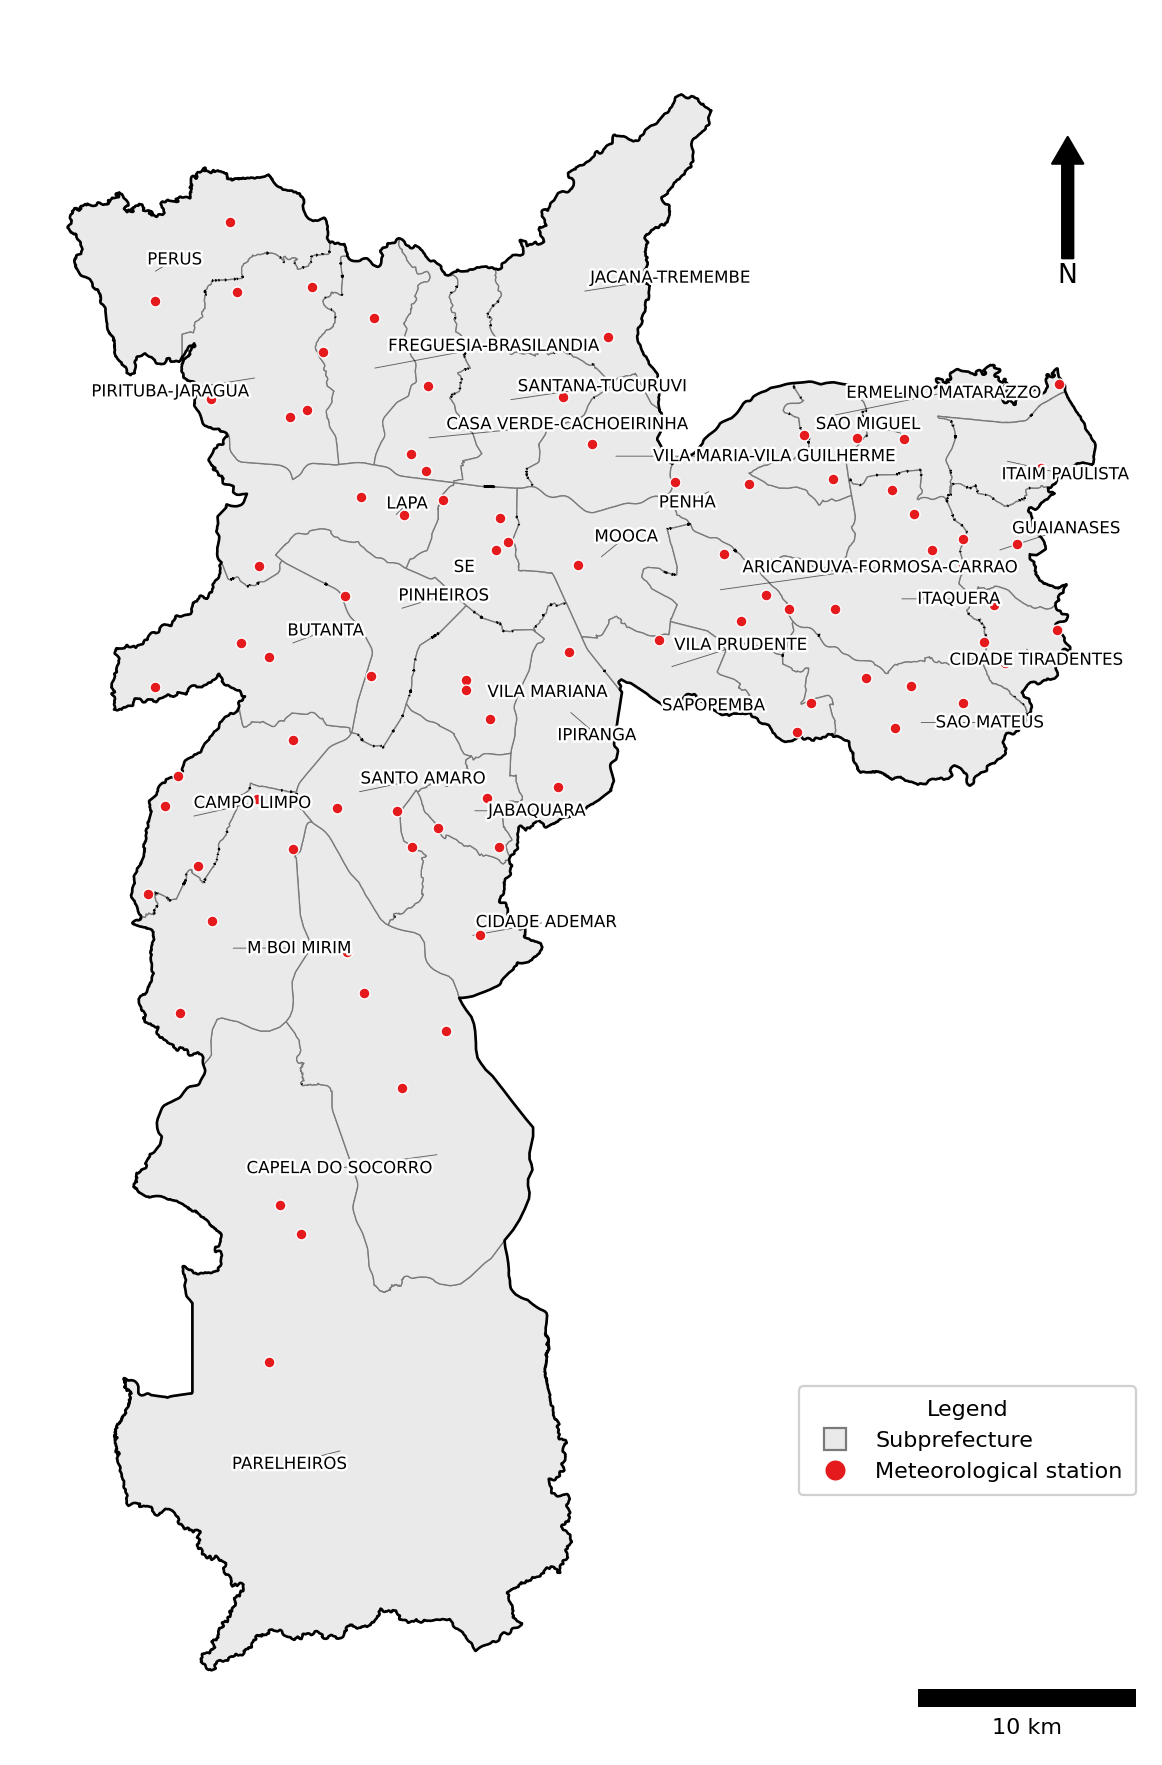

In [65]:
# -*- coding: utf-8 -*-
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patheffects as pe
from matplotlib_scalebar.scalebar import ScaleBar

# =========================================================
# Utilitários de CRS
# =========================================================
PREFERRED_METRIC_CRS = "EPSG:31983"   # SIRGAS 2000 / UTM 23S (metros)

def guess_crs_from_bounds(bounds):
    minx, miny, maxx, maxy = bounds
    # Caso evidente de graus (lat/lon)
    if (-180 <= minx <= 180) and (-90 <= miny <= 90) and (-180 <= maxx <= 180) and (-90 <= maxy <= 90):
        return "EPSG:4674"  # SIRGAS2000 (lat/lon)
    # Faixa típica UTM em metros na região de SP
    if (100000 <= min(minx, maxx) <= 900000) and (6_500_000 <= min(miny, maxy) <= 9_500_000):
        return "EPSG:31983"
    # Web Mercator (metros muito grandes)
    if (-2e7 <= minx <= 2e7) and (-2e7 <= maxx <= 2e7) and (-2e7 <= miny <= 2e7) and (-2e7 <= maxy <= 2e7):
        return "EPSG:3857"
    return None

def ensure_metric_crs(gdf, name="layer"):
    """Atribui CRS se estiver ausente (heurística por bounds) e reprojeta para EPSG:31983."""
    if gdf.crs is None:
        guess = guess_crs_from_bounds(gdf.total_bounds)
        if not guess:
            raise ValueError(
                f"{name}: CRS ausente e não foi possível inferir pelos bounds {gdf.total_bounds}. "
                "Informe manualmente com gdf.set_crs('EPSG:XXXX')."
            )
        gdf = gdf.set_crs(guess)
        print(f"{name}: CRS ausente → atribuído {guess}")
    else:
        print(f"{name}: CRS informado = {gdf.crs.to_string()}")
    if gdf.crs.to_string() != PREFERRED_METRIC_CRS:
        gdf = gdf.to_crs(PREFERRED_METRIC_CRS)
        print(f"{name}: reprojetado para {PREFERRED_METRIC_CRS}")
    else:
        print(f"{name}: já está em {PREFERRED_METRIC_CRS}")
    return gdf

# =========================================================
# Carregar dados
# =========================================================
gpd_estacoes_plu = gpd.read_file(estacoes_plu)
gpd_subprefeituras = gpd.read_file(subprefeituras_shp)

# Garantir CRS métrico
gpd_subprefeituras = ensure_metric_crs(gpd_subprefeituras, "Subprefeituras")
gpd_estacoes_plu   = ensure_metric_crs(gpd_estacoes_plu,   "Estações")

# =========================================================
# Pontos de rótulo (polylabel se disponível; senão representative_point)
# =========================================================
label_series = None
try:
    from shapely.ops import polylabel
    label_series = gpd_subprefeituras.geometry.apply(lambda g: polylabel(g, tolerance=50))
except Exception:
    label_series = gpd_subprefeituras.representative_point()
gpd_subprefeituras["label_pt"] = label_series

# =========================================================
# Figura e estilos
# =========================================================
fig, ax = plt.subplots(figsize=(9, 11), dpi=160)

# Cores/traços
face = "#eaeaea"      # preenchimento
edge_in = "#7a7a7a"   # bordas internas
pt_color = "#e41a1c"  # vermelho agradável
pt_ms = 24            # tamanho dos pontos

# Subprefeituras (polígonos)
gpd_subprefeituras.plot(ax=ax, color=face, edgecolor=edge_in, linewidth=0.6, zorder=1)

# Contorno externo mais forte para hierarquia
try:
    gpd_subprefeituras.dissolve().boundary.plot(ax=ax, color="black", linewidth=1.2, zorder=2)
except Exception:
    pass

# Estaçōes pluviométricas (como scatter, útil para repulsão)
xy = np.vstack([gpd_estacoes_plu.geometry.x.values, gpd_estacoes_plu.geometry.y.values]).T
pts = ax.scatter(xy[:, 0], xy[:, 1], s=pt_ms, c=pt_color,
                 edgecolors="white", linewidths=0.6, zorder=4, label="Meteorological station")

# =========================================================
# Rótulos com halo + anti-colisão
# =========================================================
texts = []
for _, row in gpd_subprefeituras.iterrows():
    t = ax.text(
        row["label_pt"].x, row["label_pt"].y, str(row["sp_nome"]),
        fontsize=7.5, ha="center", va="center", zorder=5,
        path_effects=[pe.withStroke(linewidth=2.2, foreground="white")]
    )
    texts.append(t)

# Repulsão (ajusta automaticamente colisões entre rótulos e com os pontos)
try:
    from adjustText import adjust_text
    adjust_text(
        texts, ax=ax, add_objects=[pts],
        expand_points=(1.2, 1.4), expand_text=(1.1, 1.3),
        force_points=(0.1, 0.3), force_text=(0.2, 0.5),
        only_move={'points': '', 'text': 'xy'},
        lim=350,
        arrowprops=dict(arrowstyle='-', lw=0.4, alpha=0.6)
    )
except Exception as e:
    print("Aviso: adjustText não disponível ou falhou; rótulos podem sobrepor.", e)

# =========================================================
# Legenda + Escala (ambos no canto inferior direito, sem sobreposição)
# =========================================================
# Handle manual para 'Subprefecture'
subpref_patch = plt.Line2D([0], [0], marker='s', linestyle="", markersize=10,
                           markerfacecolor=face, markeredgecolor=edge_in, label="Subprefecture")

# Handle manual para 'Meteorological station' (vermelho com borda branca)
estacoes_patch = plt.Line2D(
    [0], [0], marker='o', linestyle="", markersize=10,
    markerfacecolor=pt_color, markeredgecolor="white", label="Meteorological station"
)

# --- Escala embaixo; legenda acima (sem sobreposição) ---
scalebar = ScaleBar(1, units="m", dimension="si-length",
                    location="lower right", box_alpha=0.9, pad=0.4)
ax.add_artist(scalebar)

legend = ax.legend(
    handles=[subpref_patch, estacoes_patch],   # <<< usa o handle manual vermelho
    loc="lower right",
    bbox_to_anchor=(1.0, 0.14),               # ajusta para não colidir com a barra
    frameon=True, framealpha=0.92, fancybox=True, borderpad=0.6,
    title="Legend"
)

# =========================================================
# Seta de norte
# =========================================================
x, y, arrow_length = 0.93, 0.93, 0.08
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=14),
            ha='center', va='center', fontsize=12, xycoords=ax.transAxes)

# =========================================================
# Finalização
# =========================================================
ax.set_axis_off()
plt.tight_layout(pad=0.6)

# (Opcional) salvar em alta
# plt.savefig("mapa_subpref_estacoes.png", dpi=300, bbox_inches="tight")

plt.show()
